In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from google.colab import drive
import os
import torch
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import sys
import torch.nn as nn
import torchvision.models as models
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
import re
from scipy import stats
from sklearn.model_selection import train_test_split

In [ ]:
class BrainDataset(Dataset):
    def __init__(self, data_file):
        loaded      = np.load(data_file)
        self.data   = loaded['corr_matrix']      # Shape: (N, 200, 200)
        self.labels = loaded['label']    # Shape: (N,)
        self.ids    = loaded['id']        # Shape: (N,)
        self.sites = []

        # Convert string labels to numeric
        self.label_mapping = {
          'Autism'            : 0,
          'Asperger'          : 1,
          'ADHD-Combined'     : 2,
          'ADHD-Hyperactive'  : 3,
          'ADHD-Inattentive'  : 4,
        }
        self.label_name = self.labels

        self.labels = np.array([self.label_mapping[label] for label in self.labels])

    def save_data(self, file_path):
      if not os.path.exists(file_path):
          self.reverse_mapping = self.reverse_label_mapping = {v: k for k, v in self.label_mapping.items()}
          label_name = np.array([self.reverse_mapping[label] for label in self.labels])
          np.savez(file_path, corr_matrix=self.data, label=label_name, id=self.ids)
          print("File saved successfully.")
      else:
          print("File already exists. No new file created.")

    def add_sites(self, sites):
        self.sites = sites

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return each data slice as a tensor
        corr_matrix = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0)
        label       = torch.tensor(self.labels[idx], dtype=torch.long)
        subject_id  = self.ids[idx]

        return corr_matrix, label, subject_id


In [ ]:
def flatten_upper_triangle(matrix):
    """
    Flatten the upper triangular part of a square matrix, excluding the diagonal.

    Args:
    - matrix (np.array): A 190x190 matrix to be flattened.

    Returns:
    - np.array: Flattened 1D array of upper triangular elements, excluding the diagonal.
    """
    # Get the upper triangular indices (excluding the diagonal)
    upper_triangle = np.triu(matrix, k=1)

    # Flatten the upper triangular part into a 1D array
    return upper_triangle[upper_triangle != 0]



def index_to_row_col(flat_index):
    """
    Convert a flattened upper triangular index (excluding diagonal) to a row and column in the original matrix.

    Args:
    - flat_index (int): Index in the flattened upper triangular array.
    - matrix_size (int): Size of the square matrix (e.g., 190 for a 190x190 matrix).

    Returns:
    - tuple: (row, col) corresponding to the original matrix.
    """

    matrix_size = 190
    # Calculate the row using the inverse sum formula
    row = int(np.floor((2 * matrix_size - 1 - np.sqrt((2 * matrix_size - 1)**2 - 8 * flat_index)) / 2))

    # Calculate the column based on the row
    col = flat_index - (row * (2 * matrix_size - row - 1)) // 2 + row + 1

    return row, col



def calculate_feature_variance(df):
  asd_df = df[df['label']=="ASD"]
  adhd_df = df[df['label']=="ADHD"]
  asd_vars = []
  adhd_vars = []

  for i, col in enumerate(df.columns):
    if col != 'label':
      asd_var = np.var(asd_df[col].values)
      adhd_var = np.var(adhd_df[col].values)
      asd_vars.append((col, asd_var))
      adhd_vars.append((col, adhd_var))
  asd_vars.sort(key=lambda x: x[1], reverse=True)
  adhd_vars.sort(key=lambda x: x[1], reverse=True)
  return asd_vars, adhd_vars

def calculate_t_test_all_features(df):
  asd_df = df[df['label']=="ASD"]
  adhd_df = df[df['label']=="ADHD"]
  significant_feautres = []
  for i, col in enumerate(df.columns):
    if col != 'label':
      t_stat, p_value = stats.ttest_ind(asd_df[col].values, adhd_df[col].values)
      # if p_value > 0.01:
      significant_feautres.append((col, t_stat, p_value))
    if ((i+1) % 100) == 0:
      print(f"Progress: {i + 1}/{len(df.columns)-1} features processed")

  significant_feautres.sort(key=lambda x: x[2], reverse=True)
  # significant_feautres = [x[0] for x in significant_feautres]
  # sf = np.array(significant_feautres)
  # reduced_df = df[sf]
  # reduced_df['label'] = df['label']
  return significant_feautres


def parse_aal(aal):
  pairs = re.findall(r'\["(.*?)": ([\d\.]+)\]', aal)
  max_val = -9999999999
  final_name = None
  for pair in pairs:
    name = pair[0]
    val = float(pair[1])
    if val > max_val:
      max_val = val
      final_name = name
  return final_name

def clean_net_df(df, map_df):
  roi_no = []
  reg_name = []
  net_id = []
  sys_name = []

  for i in range(df.shape[0]):
    row = df.iloc[i]

    roi_map = map_df[map_df['Mapping to 200 ROIs (atlas ROI number)'] == row['ROI no.']].values
    if(roi_map.shape[0] != 0):
      roi_no.append(roi_map[0][0])
      reg_name.append(parse_aal(row['AAL']))
      net_id.append(row['NetID'])
      sys_name.append(row['Suggested System'])

  df = pd.DataFrame({'roi_no': roi_no, 'name': reg_name, 'net_id': net_id, 'sys_name': sys_name})
  sorted_df = df.sort_values(by='roi_no').reset_index(drop=True)
  return sorted_df

def convert_to_asd_adhd(df):
  asd = ['Autism', 'Asperger']
  adhd = ['ADHD-Combined', 'ADHD-Hyperactive', 'ADHD-Inattentive']
  new_labels = []
  for label in df['label']:
    if label in asd:
      new_labels.append('ASD')
    elif label in adhd:
      new_labels.append('ADHD')
  df['label'] = new_labels
  return df



def extract_site_info():
  sites = []

  site_map = {
      1 : 'PEKING',
      2 : 'BRADLEY',
      3 : 'KKI',
      4 : 'NEURO',
      5 : 'NYU',
      6 : 'OREGON',
      7 : 'PITT',
      8 : 'WU',
  }

  name = {
      'CALTECH' : 'CALTECH',
      'CMU' : 'CMU',
      'KKI' : 'KKI',
      'LEUVEN_1' : 'LEUVEN',
      'LEUVEN_2' : 'LEUVEN',
      'MAX_MUN' : 'MAX_MUN',
      'NYU' : 'NYU',
      'OLIN' : 'OLIN',
      'PITT' : 'PITT',
      'SBL' : 'SBL',
      'SDSU' : 'SDSU',
      'TRINITY' : 'TRINITY',
      'UCLA_1' : 'UCLA',
      'UCLA_2' : 'UCLA',
      'UM_1' : 'UM',
      'UM_2' : 'UM',
      'USM' : 'USM',
      'YALE' : 'YALE'

  }
  autis_df = pd.read_excel(f"{SOURCE_DIR}/ABIDE_1_Autism.xlsx")
  aspgr_df = pd.read_excel(f"{SOURCE_DIR}/ABIDE_2_Asperger.xlsx")
  adhd1_df = pd.read_excel(f"{SOURCE_DIR}/ADHD_1_ADHD1.xlsx")
  adhd2_df = pd.read_excel(f"{SOURCE_DIR}/ADHD_2_ADHD2.xlsx")
  adhd3_df = pd.read_excel(f"{SOURCE_DIR}/ADHD_3_ADHD3.xlsx")
  for i in range(autis_df.shape[0]):
    row = autis_df.iloc[i]
    sites.append(name[row['SITE_ID']])

  for i in range(aspgr_df.shape[0]):
    row = aspgr_df.iloc[i]
    sites.append(name[row['SITE_ID']])

  for i in range(adhd1_df.shape[0]):
    row = adhd1_df.iloc[i]
    sites.append(site_map[int(row['Site'])])

  for i in range(adhd2_df.shape[0]):
    row = adhd2_df.iloc[i]
    sites.append(site_map[int(row['Site'])])

  for i in range(adhd3_df.shape[0]):
    row = adhd3_df.iloc[i]
    sites.append(site_map[int(row['Site'])])

  return sites

def split_discovery_vs_replication(df):
  # 'OLIN': ASD 0
  # 'WU' : ADHD 0

  replication_sites = ['LEUVEN', 'MAX_MUN', 'TRINITY', 'SBL', 'NEURO']
  discovery_sites = ['CALTECH', 'CMU', 'NYU', 'KKI', 'PITT', 'SDSU', 'OLIN', 'UCLA', 'YALE', 'USM', 'UM', 'OREGON', 'WU', 'PEKING', 'BRADLEY']
  # discovery_sites = ['CALTECH', 'CMU', 'KKI', 'LEUVEN', 'MAX-MUN', 'KKI', 'UM', 'TRINITY', 'NEURO', 'OREGON', 'SDSU']
  # replication_sites = ['NYU', 'PITT', 'SBL', 'UCLA', 'USM', 'YALE', 'PEKING']

  discovery_df = df[df['site'].isin(discovery_sites)]
  replication_df = df[df['site'].isin(replication_sites)]

  return discovery_df, replication_df

In [ ]:
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
SOURCE_DIR = '/content/drive/MyDrive/BrainMapper'

In [ ]:
dataset = BrainDataset(f"{SOURCE_DIR}/adhd_autism_balanced.npz")
map_df = pd.read_excel(f"{SOURCE_DIR}/mapping_from_190_to_200_ROIs.xlsx")
net_df = clean_net_df(pd.read_excel(f"{SOURCE_DIR}/brainnet/ABIDE_CC200_ROI_labels_netID.xlsx"), map_df)

In [ ]:
sites = extract_site_info()

In [ ]:
dataset.add_sites(sites)

In [ ]:
flattened_data = np.array([flatten_upper_triangle(data) for data in dataset.data])

In [ ]:
disorders_df = pd.DataFrame(flattened_data)
disorders_df['label'] = dataset.label_name
disorders_df['site'] = dataset.sites
disorders_df = convert_to_asd_adhd(disorders_df)
# disorders_df = disorders_df.drop(index=602)

In [ ]:
disorders_df

0         1         2         3         4         5         6  \
0   -0.159003  0.121674 -0.110528  0.040946  0.061012  0.218532 -0.116653   
1    0.134749 -0.030202 -0.022602 -0.124251  0.311727  0.260374 -0.215447   
2   -0.008385 -0.106489  0.021105 -0.170466  0.012640 -0.077925  0.198790   
3   -0.083274  0.160009 -0.043249  0.100278  0.128468 -0.153655 -0.095791   
4   -0.002659 -0.130369 -0.130934  0.199572  0.519946  0.019540  0.131425   
..        ...       ...       ...       ...       ...       ...       ...   
784 -0.122717  0.116301 -0.144153 -0.067895  0.035930  0.083082 -0.042607   
785  0.070323 -0.426320 -0.130980 -0.406507 -0.331305  0.668001 -0.029118   
786  0.217768  0.044758  0.121610 -0.010863  0.169100  0.549613 -0.023648   
787  0.072705 -0.169827 -0.183667 -0.026850  0.106967 -0.307535  0.091945   
788 -0.114707  0.076896 -0.424168 -0.016138  0.006918 -0.295004 -0.231188   

            7         8         9  ...     17947     17948     17949  \
0   -0.127646 -0.072935  0.159911  ...  0.034595 -0.036011 -0.167147   
1    0.026495 -0.146986  0.296062  ... -0.092513 -0.241298  0.142973   
2   -0.092148  0.101080  0.174465  ... -0.256040 -0.068893  0.062609   
3   -0.030722 -0.163404 -0.106271  ... -0.236650 -0.006124  0.266625   
4   -0.124215 -0.042407  0.351939  ...  0.034837 -0.023036 -0.022289   
..        ...       ...       ...  ...       ...       ...       ...   
784  0.113966  0.123379  0.202125  ...  0.097179 -0.014457  0.125590   
785  0.017075 -0.466841  0.570739  ... -0.300257 -0.402185  0.076603   
786  0.068217 -0.227158  0.259704  ... -0.111034 -0.322116  0.190658   
787 -0.068768 -0.154723  0.075556  ... -0.074016 -0.002468  0.060399   
788 -0.098505  0.093069 -0.214435  ...  0.041189 -0.022945 -0.025311   

        17950     17951     17952     17953     17954  label    site  
0   -0.024334  0.058773  0.379620 -0.257534  0.037078    ASD    PITT  
1   -0.017589  0.003593  0.156665  0.093604  0.145610    ASD    PITT  
2   -0.040470 -0.056836  0.342685 -0.208628  0.055516    ASD    PITT  
3   -0.021530 -0.037560  0.321644 -0.061440  0.089409    ASD    PITT  
4    0.088563  0.219354  0.286932 -0.274767  0.083007    ASD    PITT  
..        ...       ...       ...       ...       ...    ...     ...  
784  0.092041 -0.116011  0.062645 -0.166518 -0.011614   ADHD  PEKING  
785  0.237105  0.254215 -0.132144 -0.254622  0.323329   ADHD  OREGON  
786  0.010924 -0.183800  0.366018 -0.340124 -0.191144   ADHD  PEKING  
787  0.072375  0.105013  0.026564 -0.215515  0.091839   ADHD  PEKING  
788 -0.168010  0.230483  0.034338  0.100965 -0.299656   ADHD     NYU  

[789 rows x 17957 columns]

In [ ]:
discovery_df, replication_df = split_discovery_vs_replication(disorders_df)
print(discovery_df.shape, replication_df.shape)
discovery_df = discovery_df.drop(columns=['site'])
replication_df = replication_df.drop(columns=['site'])

(674, 17957) (115, 17957)


In [ ]:
len(dataset.data)

789

In [ ]:
discovery_df.iloc[100]

0       -0.079977
1        0.060534
2        -0.00899
3        0.213545
4        0.315325
           ...   
17951   -0.045668
17952    0.252801
17953    0.096383
17954   -0.006762
label         ASD
Name: 110, Length: 17956, dtype: object

In [ ]:
sf = calculate_t_test_all_features(disorders_df)

Progress: 100/17956 features processed
Progress: 200/17956 features processed
Progress: 300/17956 features processed
Progress: 400/17956 features processed
Progress: 500/17956 features processed
Progress: 600/17956 features processed
Progress: 700/17956 features processed
Progress: 800/17956 features processed
Progress: 900/17956 features processed
Progress: 1000/17956 features processed
Progress: 1100/17956 features processed
Progress: 1200/17956 features processed
Progress: 1300/17956 features processed
Progress: 1400/17956 features processed
Progress: 1500/17956 features processed
Progress: 1600/17956 features processed
Progress: 1700/17956 features processed
Progress: 1800/17956 features processed
Progress: 1900/17956 features processed
Progress: 2000/17956 features processed
Progress: 2100/17956 features processed
Progress: 2200/17956 features processed
Progress: 2300/17956 features processed
Progress: 2400/17956 features processed
Progress: 2500/17956 features processed
Progress:

KeyboardInterrupt: 

In [ ]:
train_df, test_df = train_test_split(
    disorders_df, test_size=0.5, stratify=disorders_df['label'], random_state=42
)

In [ ]:
# test_df = test_df.drop(index=602)

In [ ]:
train_sf = calculate_t_test_all_features(train_df)

Progress: 100/17955 features processed
Progress: 200/17955 features processed
Progress: 300/17955 features processed
Progress: 400/17955 features processed
Progress: 500/17955 features processed
Progress: 600/17955 features processed
Progress: 700/17955 features processed
Progress: 800/17955 features processed
Progress: 900/17955 features processed
Progress: 1000/17955 features processed
Progress: 1100/17955 features processed
Progress: 1200/17955 features processed
Progress: 1300/17955 features processed
Progress: 1400/17955 features processed
Progress: 1500/17955 features processed
Progress: 1600/17955 features processed
Progress: 1700/17955 features processed
Progress: 1800/17955 features processed
Progress: 1900/17955 features processed
Progress: 2000/17955 features processed
Progress: 2100/17955 features processed
Progress: 2200/17955 features processed
Progress: 2300/17955 features processed
Progress: 2400/17955 features processed
Progress: 2500/17955 features processed
Progress:

In [ ]:
test_sf = calculate_t_test_all_features(test_df)

Progress: 100/17955 features processed
Progress: 200/17955 features processed
Progress: 300/17955 features processed
Progress: 400/17955 features processed
Progress: 500/17955 features processed
Progress: 600/17955 features processed
Progress: 700/17955 features processed
Progress: 800/17955 features processed
Progress: 900/17955 features processed
Progress: 1000/17955 features processed
Progress: 1100/17955 features processed
Progress: 1200/17955 features processed
Progress: 1300/17955 features processed
Progress: 1400/17955 features processed
Progress: 1500/17955 features processed
Progress: 1600/17955 features processed
Progress: 1700/17955 features processed
Progress: 1800/17955 features processed
Progress: 1900/17955 features processed
Progress: 2000/17955 features processed
Progress: 2100/17955 features processed
Progress: 2200/17955 features processed
Progress: 2300/17955 features processed
Progress: 2400/17955 features processed
Progress: 2500/17955 features processed
Progress:

In [ ]:
def overlapping_coefficient(data1, data2):
  # Step 1: Create histograms with the same bins
  bins = np.linspace(-4, 4, 50)  # Define bin edges
  hist1, _ = np.histogram(data1, bins=bins, density=True)
  hist2, _ = np.histogram(data2, bins=bins, density=True)

  # Step 2: Calculate the overlap
  overlap = np.sum(np.minimum(hist1, hist2) * np.diff(bins))  # Use bin widths
  # print(f"Overlap coefficient: {overlap}")
  return overlap

def calculate_overlaps(df, sf):

  ovls = []

  labels = df['label'].values

  for i in range(100, df.shape[1], 100):
    print(f"calculate_overlaps - Progress: {i}/{df.shape[1]}")
    # off = i
    array_sf = np.array(sf)
    selected_features = array_sf[0:i, 0]

    filt_df = df[selected_features]
    pca = PCA(n_components=1)
    # disorders_df = disorders_df.drop(index=602)
    pca_data = pca.fit_transform(filt_df.iloc[:, :-1].values)

    asd_data = pca_data[labels == 'ASD']
    adhd_data = pca_data[labels == 'ADHD']
    ovl  = overlapping_coefficient(asd_data, adhd_data)
    ovls.append([i, ovl])
  return ovls

def plot_overlaps(ovls):
  ovls = np.array(ovls)
  plt.xlabel("Upper bound", fontsize = 16)
  plt.ylabel("Overlap", fontsize = 16)
  plt.xticks(fontsize = 13)
  plt.yticks(fontsize = 13)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.plot(ovls[:, 0], ovls[:, 1], linewidth=4)

In [ ]:
plot_overlaps(ovls)

NameError: name 'ovls' is not defined

In [ ]:
# scaler = StandardScaler()
# scaler.fit(disorders_df.iloc[:, :-1])
# disorders_df.iloc[:, :-1] = scaler.transform(disorders_df.iloc[:, :-1])

In [ ]:
ovls = calculate_overlaps(disorders_df, sf)

calculate_overlaps - Progress: 100/17956
calculate_overlaps - Progress: 200/17956
calculate_overlaps - Progress: 300/17956
calculate_overlaps - Progress: 400/17956
calculate_overlaps - Progress: 500/17956
calculate_overlaps - Progress: 600/17956
calculate_overlaps - Progress: 700/17956
calculate_overlaps - Progress: 800/17956
calculate_overlaps - Progress: 900/17956
calculate_overlaps - Progress: 1000/17956
calculate_overlaps - Progress: 1100/17956
calculate_overlaps - Progress: 1200/17956
calculate_overlaps - Progress: 1300/17956
calculate_overlaps - Progress: 1400/17956
calculate_overlaps - Progress: 1500/17956
calculate_overlaps - Progress: 1600/17956
calculate_overlaps - Progress: 1700/17956
calculate_overlaps - Progress: 1800/17956
calculate_overlaps - Progress: 1900/17956
calculate_overlaps - Progress: 2000/17956
calculate_overlaps - Progress: 2100/17956
calculate_overlaps - Progress: 2200/17956
calculate_overlaps - Progress: 2300/17956
calculate_overlaps - Progress: 2400/17956
c

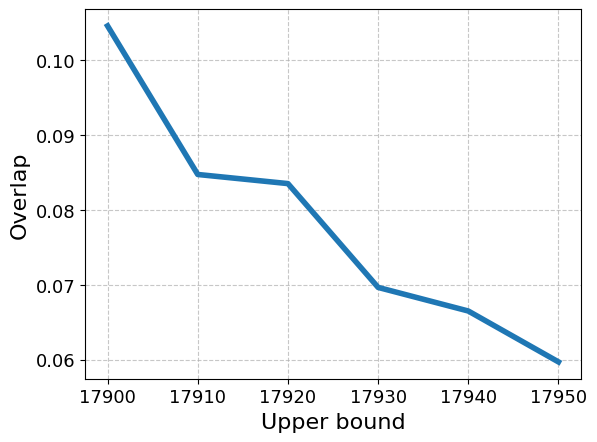

In [ ]:
plot_overlaps(ovls)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
ovls_train = calculate_overlaps(train_df, sf)

calculate_overlaps - Progress: 100/17956
calculate_overlaps - Progress: 200/17956
calculate_overlaps - Progress: 300/17956
calculate_overlaps - Progress: 400/17956
calculate_overlaps - Progress: 500/17956
calculate_overlaps - Progress: 600/17956
calculate_overlaps - Progress: 700/17956
calculate_overlaps - Progress: 800/17956
calculate_overlaps - Progress: 900/17956
calculate_overlaps - Progress: 1000/17956
calculate_overlaps - Progress: 1100/17956
calculate_overlaps - Progress: 1200/17956
calculate_overlaps - Progress: 1300/17956
calculate_overlaps - Progress: 1400/17956
calculate_overlaps - Progress: 1500/17956
calculate_overlaps - Progress: 1600/17956
calculate_overlaps - Progress: 1700/17956
calculate_overlaps - Progress: 1800/17956
calculate_overlaps - Progress: 1900/17956
calculate_overlaps - Progress: 2000/17956
calculate_overlaps - Progress: 2100/17956
calculate_overlaps - Progress: 2200/17956
calculate_overlaps - Progress: 2300/17956
calculate_overlaps - Progress: 2400/17956
c

In [ ]:
ovls_test = calculate_overlaps(test_df, test_sf)

calculate_overlaps - Progress: 100/17956
calculate_overlaps - Progress: 200/17956
calculate_overlaps - Progress: 300/17956
calculate_overlaps - Progress: 400/17956
calculate_overlaps - Progress: 500/17956
calculate_overlaps - Progress: 600/17956
calculate_overlaps - Progress: 700/17956
calculate_overlaps - Progress: 800/17956
calculate_overlaps - Progress: 900/17956
calculate_overlaps - Progress: 1000/17956
calculate_overlaps - Progress: 1100/17956
calculate_overlaps - Progress: 1200/17956
calculate_overlaps - Progress: 1300/17956
calculate_overlaps - Progress: 1400/17956
calculate_overlaps - Progress: 1500/17956
calculate_overlaps - Progress: 1600/17956
calculate_overlaps - Progress: 1700/17956
calculate_overlaps - Progress: 1800/17956
calculate_overlaps - Progress: 1900/17956
calculate_overlaps - Progress: 2000/17956
calculate_overlaps - Progress: 2100/17956
calculate_overlaps - Progress: 2200/17956
calculate_overlaps - Progress: 2300/17956
calculate_overlaps - Progress: 2400/17956
c

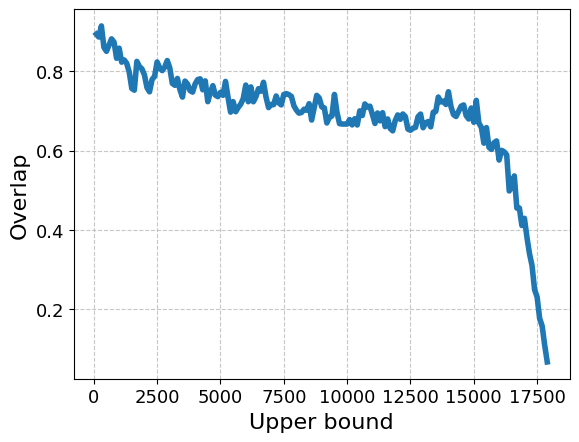

In [ ]:
plot_overlaps(ovls_train)

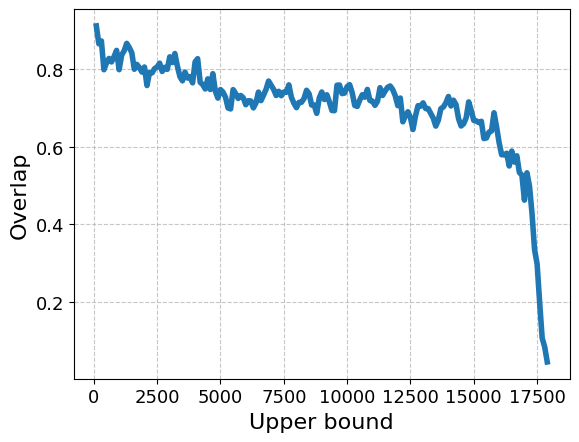

In [ ]:
plot_overlaps(ovls_test)

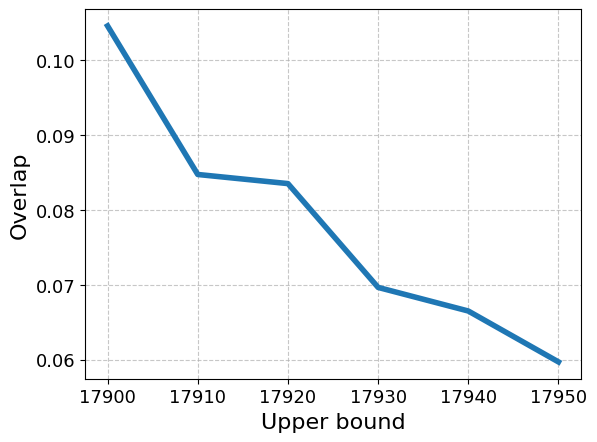

In [ ]:
plot_overlaps(ovls)

In [ ]:
def filter_uppper_bounds(ovls, ovl_min, ovl_max):
  upper_bounds = []
  for ovl in ovls:
    if ovl[1] <= ovl_max and ovl[1] >= ovl_min:
      upper_bounds.append(ovl)
  return upper_bounds

In [ ]:
upper_bounds = filter_uppper_bounds(ovls, 0.0, 0.55)

In [ ]:
upper_bounds

[[17300, 0.5096627510420614],
 [17400, 0.4745112414467253],
 [17500, 0.4419130480774316],
 [17600, 0.37950499348675637],
 [17700, 0.2958989937345737],
 [17800, 0.20862356147789218],
 [17900, 0.09775078064012489]]

In [ ]:
up_bounds_train = filter_uppper_bounds(ovls_train,0.0, 0.55)

In [ ]:
up_bounds_train

[[16400, 0.4979388526279629],
 [16500, 0.5085102649587647],
 [16600, 0.5359050183166351],
 [16700, 0.45462737676849596],
 [16800, 0.4548319327731092],
 [16900, 0.4106481481481481],
 [17000, 0.428921568627451],
 [17100, 0.3805558199295707],
 [17200, 0.3394803871625064],
 [17300, 0.30972972972972973],
 [17400, 0.24898373983739838],
 [17500, 0.23034789936198385],
 [17600, 0.17628575092984478],
 [17700, 0.1567372756693145],
 [17800, 0.10818608005769922],
 [17900, 0.06624917600527357]]

In [ ]:
up_bounds_test = filter_uppper_bounds(ovls_test, 0.0, 0.55)

In [ ]:
up_bounds_test

[[16800, 0.5340898896564098],
 [16900, 0.5270975511842633],
 [17000, 0.46255303449548046],
 [17100, 0.5331359816653934],
 [17200, 0.49863294600136704],
 [17300, 0.42770068027210884],
 [17400, 0.3345306513409962],
 [17500, 0.2979030144167759],
 [17600, 0.19934802636241228],
 [17700, 0.10675990675990675],
 [17800, 0.08366115919223709],
 [17900, 0.04504504504504504]]

In [ ]:
def plot_projection_function(df, proj_f):
  if proj_f == "PC1":
    pca = PCA(n_components=1)
    pca_data = pca.fit_transform(df.iloc[:, :-1].values)
    x = pca_data

  elif proj_f == "l1norm":
    l1norm = np.linalg.norm(df.iloc[:, :-1].values, ord=1, axis=1)
    x = l1norm

  elif proj_f == "l2norm":
    l2norm = np.linalg.norm(df.iloc[:, :-1].values, ord=2, axis=1)
    x = l2norm

  labels = df.iloc[:, -1].values  # Labels
  # Encode the labels to numeric values
  encoded_labels = LabelEncoder().fit_transform(labels)

  # Separate x values by class
  class_0_x = x[encoded_labels == 0]  # x values for class 0
  class_1_x = x[encoded_labels == 1]  # x values for class 1

  # Get the original class labels (before encoding)
  original_labels = np.unique(labels)

  # Plot histograms for each class
  plt.hist(class_0_x, bins=20, alpha=0.7, label=original_labels[0], color='#1f77b4', edgecolor='black')
  plt.hist(class_1_x, bins=20, alpha=0.7, label=original_labels[1], color='#ff7f0e', edgecolor='black')

  # Add labels and title
  plt.xlabel(proj_f, fontsize=16)
  plt.ylabel('Frequency', fontsize=16)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)


  # Add legend with original string labels
  plt.legend(title="Classes")

  # Show plot
  plt.show()
  # return pca_data

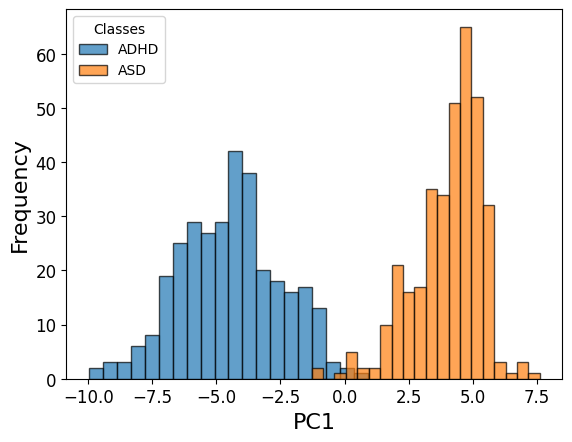

In [ ]:
pca_data = plot_projection_function(discovery_df, "PC1")

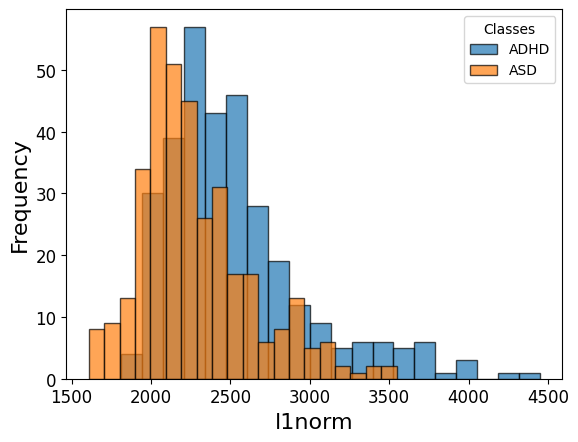

In [ ]:
plot_projection_function(discovery_df, "l1norm")

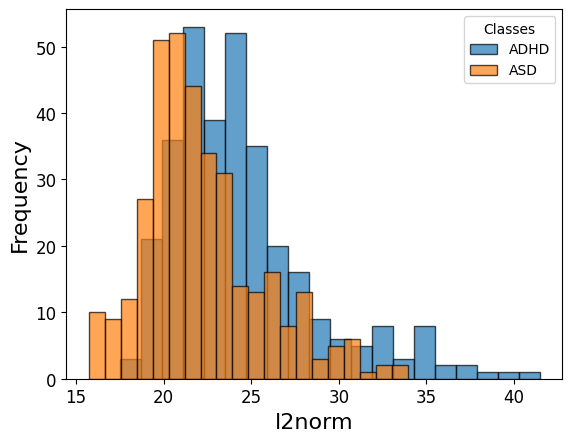

In [ ]:
plot_projection_function(discovery_df, "l2norm")

In [ ]:
# def plot_overlapping_area_on_pca(df, sf, up_bound):
#   array_sf = np.array(sf)
#   selected_features = array_sf[0:up_bound, 0]
#   # if 602 in df.index:
#   #   df = df.drop(602)

#   # df = df.drop(index = 602)
#   filt_df = df[selected_features]
#   pca = PCA(n_components=1)
#   pca_data = pca.fit_transform(filt_df.iloc[:, :-1].values)

#   # Assuming disorders_df is your DataFrame
#   x = pca_data # Feature 1
#   labels = df.iloc[:, -1].values  # Labels

#   # Encode the labels to numeric values
#   encoded_labels = LabelEncoder().fit_transform(labels)

#   # Separate x values by class
#   class_0_x = x[encoded_labels == 0]  # x values for class 0
#   class_1_x = x[encoded_labels == 1]  # x values for class 1

#   # Get the original class labels (before encoding)
#   original_labels = np.unique(labels)

#   # Plot histograms for each class
#   plt.hist(class_0_x, bins=20, alpha=0.7, label=original_labels[0], color='#1f77b4', edgecolor='black')
#   plt.hist(class_1_x, bins=20, alpha=0.7, label=original_labels[1], color='#ff7f0e', edgecolor='black')

#   # Add labels and title
#   plt.xlabel('PC1', fontsize=16)
#   plt.ylabel('Frequency', fontsize=16)
#   plt.xticks(fontsize=12)
#   plt.yticks(fontsize=12)
#   plt.title('Histogram of x for Class 0 and Class 1')

#   # Add legend with original string labels
#   plt.legend(title="Classes")

#   # Show plot
#   plt.show()

In [ ]:
def plot_overlapping_area(df):
  # if 602 in df.index:
  #   df = df.drop(602)

  # df = df.drop(index = 602)
  # pca = PCA(n_components=1)
  # pca_data = pca.fit_transform(df.iloc[:, :-1].values).reshape(-1)


  # Assuming disorders_df is your DataFrame
  x = df.iloc[:, :-1].values # Feature 1
  labels = df.iloc[:, -1].values  # Labels

  # Encode the labels to numeric values
  encoded_labels = LabelEncoder().fit_transform(labels)

  # Separate x values by class
  class_0_x = x[encoded_labels == 0]  # x values for class 0
  class_1_x = x[encoded_labels == 1]  # x values for class 1

  # Get the original class labels (before encoding)
  original_labels = np.unique(labels)

  # Plot histograms for each class
  plt.hist(class_0_x, bins=20, alpha=0.7, label=original_labels[0], color='#1f77b4', edgecolor='black')
  plt.hist(class_1_x, bins=20, alpha=0.7, label=original_labels[1], color='#ff7f0e', edgecolor='black')

  # Add labels and title
  plt.xlabel('PC1', fontsize=16)
  plt.ylabel('Frequency', fontsize=16)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title('Histogram of x for Class 0 and Class 1')

  # Add legend with original string labels
  plt.legend(title="Classes")

  # Show plot
  plt.show()


def get_features_contribution_on_pca(df):
  # array_sf = np.array(sf)
  # selected_features = array_sf[0:, 0]
  # selected_features = np.sort(selected_features)

  # filt_df = df[selected_features]
  pca = PCA(n_components=1)
  pca_data = pca.fit_transform(df.iloc[:, :-1].values)

  W = pca.components_.T.flatten()

  return W

def project_data_to_pca_axis(df, weight):
  X_centered = df.iloc[:, :-1].values - np.mean(df.iloc[:, :-1].values, axis=0)
  xw = np.dot(X_centered, weight)
  final_df = pd.DataFrame(xw, columns=['PC1'])
  # print(final_df.shape, df['label'].shape)
  final_df['label'] = df['label'].reset_index(drop=True)
  return final_df


In [ ]:
# discovery_df.to_csv(f"{SOURCE_DIR}/discovery_df.csv", index=False)

In [ ]:
disc_weight = get_features_contribution_on_pca(discovery_df)

In [ ]:
projected_repli_df = project_data_to_pca_axis(replication_df, disc_weight)

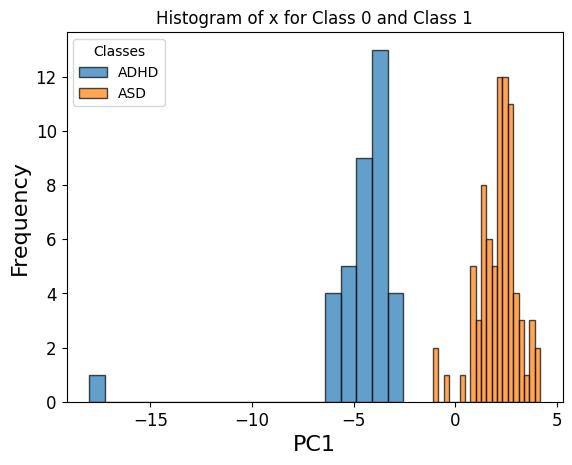

In [ ]:
plot_overlapping_area(projected_repli_df)

In [ ]:
def extract_bin_intervals(df, num_intervals, perc_overlap):
    # Extract labels
    labels = df['label'].values

    # Apply PCA (reduce to 1D)
    pca = PCA(n_components=1)
    pca_data = pca.fit_transform(df.iloc[:, :-1].values).flatten()  # Convert to 1D array

    # Compute min and max values of PCA-transformed data
    bound_min, bound_max = np.min(pca_data), np.max(pca_data)

    # Compute interval length based on Mapper algorithm
    total_length = bound_max - bound_min
    interval_length = total_length / (num_intervals * (1 - perc_overlap / 100) + perc_overlap / 100)
    overlap_length = interval_length * (perc_overlap / 100)

    # Generate bin intervals
    bins = []
    start_of_interval = bound_min

    for i in range(num_intervals):
        end_of_interval = start_of_interval + interval_length
        bins.append((start_of_interval, end_of_interval))

        # Shift start for the next interval (overlap at the beginning except the first one)
        start_of_interval = end_of_interval - overlap_length if i > 0 else end_of_interval

    return np.array(bins)

def classify_val_data_on_train_bins(train_df, test_df):
    # Extract labels
    bins = extract_bin_intervals(train_df, 15, 35)
    labels = train_df['label'].values

    pca_weight = get_features_contribution_on_pca(train_df)

    projected_test_df = project_data_to_pca_axis(test_df, pca_weight)
    projected_test = projected_test_df['PC1'].values

    classifications = np.full(len(projected_test), -1)  # Default to -1 (no bin found)

    for i, value in enumerate(projected_test):
        for bin_idx, (start, end) in enumerate(bins):
            # print(start, end, value)
            if start <= value and value < end:  # Assign data point to the correct bin
                classifications[i] = bin_idx + 1
                break  # Stop searching once a match is found

    test_df = test_df.reset_index(drop=True)
    test_df['bin'] = classifications

    test_df = test_df[test_df['bin'] != -1]
    test_df = test_df.reset_index(drop=True)
    return test_df






In [ ]:
val_df = classify_val_data_on_train_bins(discovery_df, replication_df)

In [ ]:
val_df['bin'].unique()

array([10,  9, 11, 12,  7,  8,  4,  3,  5,  6])

In [ ]:
def count_outliers(labels):
    return len([label for label in labels if label == -1])

def count_non_outliers(labels):
    return len([label for label in labels if label != -1])

def count_clusters(labels):
    return len(set(labels)) - (1 if -1 in labels else 0)

def get_proper_epsilon(df, eps_start, eps_end, eps_step, min_pts):
  data = df.to_numpy()
  X_data, y_data = data[:, :-2], data[:, -2]

  outliers = []
  non_outliers = []
  clusters = []
  outliers_percentage = []

  eps_range = np.arange(eps_start, eps_end, eps_step)


  for eps in eps_range:
    print(f"get_proper_epsilon - Progress: {eps}/{eps_end}")
  # Create DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_pts, metric='euclidean')

    # Fit the model to the scaled data
    dbscan.fit(X_data)

    # Get the cluster labels (-1 means outliers)
    labels = dbscan.labels_

    n_outliers = count_outliers(labels)
    n_non_outliers = count_non_outliers(labels)
    n_clusters = count_clusters(labels)
    n_outliers_percentage = n_outliers / len(labels) * 100

    outliers.append(n_outliers)
    non_outliers.append(n_non_outliers)
    clusters.append(n_clusters)
    outliers_percentage.append(n_outliers_percentage)
    if n_clusters == 1 and n_outliers_percentage <= 10:
      return eps

  return None

In [ ]:
discovery_df.shape

(674, 17956)

In [ ]:
start_eps = 50
end_eps = start_eps + 10
eps = get_proper_epsilon(discovery_df, 22, 35, 1, 5)

get_proper_epsilon - Progress: 22/35
get_proper_epsilon - Progress: 23/35
get_proper_epsilon - Progress: 24/35
get_proper_epsilon - Progress: 25/35
get_proper_epsilon - Progress: 26/35
get_proper_epsilon - Progress: 27/35
get_proper_epsilon - Progress: 28/35
get_proper_epsilon - Progress: 29/35


In [ ]:
def plot_epsilon_vs_outlier(df, plot_label, eps_start, eps_end, eps_step, min_pts):
  data = df.to_numpy()
  X_data, y_data = data[:, :-2], data[:, -2]

  outliers = []
  non_outliers = []
  clusters = []
  outliers_percentage = []

  eps_range = np.arange(eps_start, eps_end, eps_step)


  for eps in eps_range:
  # Create DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_pts, metric='euclidean')

    # Fit the model to the scaled data
    dbscan.fit(X_data)

    # Get the cluster labels (-1 means outliers)
    labels = dbscan.labels_

    n_outliers = count_outliers(labels)
    n_non_outliers = count_non_outliers(labels)
    n_clusters = count_clusters(labels)
    n_outliers_percentage = n_outliers / len(labels) * 100

    outliers.append(n_outliers)
    non_outliers.append(n_non_outliers)
    clusters.append(n_clusters)
    outliers_percentage.append(n_outliers_percentage)

  x = eps_range

  # Create a plot
  fig, ax1 = plt.subplots()

  # Plot outliers on the left y-axis
  ax1.plot(x, outliers_percentage, label='Outliers Percentage(%)', color='g', linewidth=4)
  ax1.set_xlabel('Epsilon', fontsize=16)
  ax1.set_ylabel('Outliers (%)', color='g', fontsize=16)
  ax1.tick_params(axis='y', labelcolor='g')

  # Create a second y-axis
  ax2 = ax1.twinx()

  # Plot clusters on the right y-axis
  ax2.plot(x, clusters, label='Clusters', color='b', linewidth=4)
  ax2.set_ylabel('Number of Clusters', color='b', fontsize=16)
  ax2.tick_params(axis='y', labelcolor='b')
  print(outliers_percentage)
  ax1.set_xticks(np.arange(eps_start, eps_end, 1))
  ax1.set_yticks(np.arange(0, 100, 10))
  ax2.set_yticks(np.arange(0, 10, 1))


  ax1.set_xticklabels(ax1.get_xticks(), fontsize=13)
  ax1.set_yticklabels(ax1.get_yticks(), fontsize=13)
  ax2.set_yticklabels(ax2.get_yticks(), fontsize=13)

  # Add a title and legends
  # plt.title(f"DBSCAN Analysis ({plot_label};min_pts={min_pts})")
  # ax1.legend(loc='upper left')
  # ax2.legend(loc='upper right')

[70.91988130563797, 52.22551928783383, 38.27893175074184, 30.267062314540063, 22.8486646884273, 14.688427299703264, 10.979228486646884, 7.71513353115727, 6.6765578635014835, 5.192878338278932, 4.154302670623145, 3.2640949554896146, 2.6706231454005933]


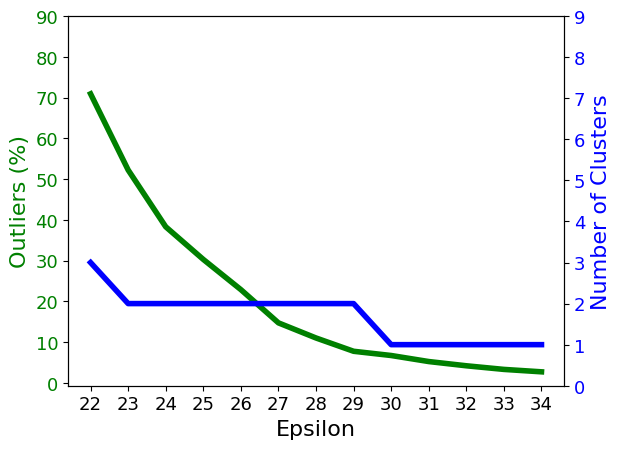

In [ ]:
plot_epsilon_vs_outlier(discovery_df, 'All Disorders', 22, 35, 1, 2)

In [ ]:
import json
def open_mapper_graph(path):
  with open(path, 'r') as file:
    graph_file = json.load(file)
    return graph_file

from scipy.stats import pearsonr
from scipy.stats import ttest_ind

def get_subject_ids_from_node(graph_file, dataset, node_id):
  map_node_id = list(graph_file['nodes'].keys())
  node = graph_file['nodes'][map_node_id[node_id-1]]['vertices']

  subject_ids = []
  for i, subject_id in enumerate(dataset.ids):
    if i in node:
      subject_ids.append(subject_id)

  return subject_ids

def filter_by_mapper_node(graph_file, df, node_id):
  map_node_id = list(graph_file['nodes'].keys())
  node = graph_file['nodes'][map_node_id[node_id-1]]['vertices']

  row_ids = []
  for i in node:
    row_ids.append(i)

  return df.iloc[row_ids]

def filter_by_multiple_mapper_nodes(graph_file, df, node_ids):
  map_node_id = list(graph_file['nodes'].keys())
  nodes = []
  for node_id in node_ids:
    node = graph_file['nodes'][map_node_id[node_id-1]]['vertices']
    nodes.extend(node)

  row_ids = []
  for i in nodes:
    row_ids.append(i)

  row_ids = np.unique(row_ids)
  return df.iloc[row_ids]


def significant_features_two_adjacent_nodes(graph_file, df, node1, node):
  df1 = filter_by_mapper_node(graph_file, df, node1)
  df2 = filter_by_mapper_node(graph_file, df, node)

  significant_features = []
  for col in disorders_df.columns:
    if col != 'label':
      group1 = df1[col].values
      group2 = df2[col].values
      t_stat, p_value = ttest_ind(group1, group2)
      if p_value < 0.05:
        significant_features.append((col, p_value))
      # print("\nIndependent t-test:")
      # print("T-statistic:", t_stat)
      # print("P-value:", p_value)
  return significant_features

def features_correlation_with_pca(df, pca_df, disorder=None):
  corr_p_features = []
  if disorder != None:
    df = df[df['label'] == disorder]
    pca_df = pca_df[pca_df['label'] == disorder]

  progress = 0
  for i, col in enumerate(df.columns):
    if progress % 100 == 0:
      print(f"features_correlation_with_pca ({disorder})- Progress: {progress}/{df.shape[1]-1}")
    progress += 1

    if col != 'label':
      x = df[col].values
      y = pca_df['PC1'].values
      # print(x.shape, y.shape)
      correlation, p_value = pearsonr(x, y)
      if(p_value < 0.02):
        corr_p_features.append((col, correlation, p_value))
  corr_p_features = sorted(corr_p_features, key=lambda x: x[2])
  return corr_p_features

def t_test_asd_vs_adhd(df, graph_file, feature, node_id):
  node_df = filter_by_mapper_node(graph_file, df, node_id)
  group1 = node_df[node_df['label'] == 'ASD'][feature].values
  group2 = node_df[node_df['label'] == 'ADHD'][feature].values
  # group1 = filter_by_mapper_node(graph_file, df, node_id)['label']
  # group2 = df[df['label'] == 'ASD']['label'].values
  t_stat, p_value = ttest_ind(group1, group2)

  # return group1, group2
  return (feature, t_stat, p_value)

def get_shared_features_intermediate_nodes(df, graph_file, node_ids):
  shared_features = []

  progress = 0
  for i, col in enumerate(df.columns):
    if progress % 100 == 0:
      print(f"get_shared_features_intermediate_nodes - Progress: {progress}/{df.shape[1]-1}")
    progress += 1

    if col != 'label':
      red_flag = 0
      for node_id in node_ids:
        col, t_stat, p_val = t_test_asd_vs_adhd(df, graph_file, col, node_id)
        if p_val <= 0.4:
          red_flag = 1
          break
      if red_flag == 0:
        shared_features.append((col, t_stat, p_val))

  shared_features = sorted(shared_features, key=lambda x: x[2], reverse=True)
  return shared_features

In [ ]:
def get_mapper_features(reduced_df, graph_file, inter_nodes):
  # asd_df = df[df['label'] == 'ASD']
  # adhd_df = df[df['label'] == 'ADHD']

  pca = PCA(n_components=1)
  pca_data = pca.fit_transform(reduced_df.iloc[:, :-1].values)
  pca_df = pd.DataFrame(pca_data, columns=['PC1'])
  pca_df['label'] = reduced_df['label'].values

  asd_corr_p_features = features_correlation_with_pca(reduced_df, pca_df, "ASD")
  adhd_corr_p_features = features_correlation_with_pca(reduced_df, pca_df, "ADHD")
  overall_corr_p_features = features_correlation_with_pca(reduced_df, pca_df)

  print(overall_corr_p_features)
  print(asd_corr_p_features)
  print(adhd_corr_p_features)
  asd_features = set()
  adhd_features = set()

  feature_corr = dict()


  for feature, correlation, p_value in asd_corr_p_features:
    # asd_features.add(feature)
    feature_corr[feature] = [correlation, None, None]

  for feature, correlation, p_value in adhd_corr_p_features:
    if feature not in feature_corr:
      feature_corr[feature] = [None, correlation, None]
    else:
      feature_corr[feature][1] = correlation

  for feature, correlation, p_value in overall_corr_p_features:
    if feature in feature_corr:
      feature_corr[feature][2] = correlation

  significant_features = list(feature_corr.keys())
  # significant_features = []
  # for feature, correlation, p_value in corr_p_features:
  #   if (p_value < 0.05):
  #     significant_features.append((feature, correlation, p_value))


  sf = np.array(significant_features)
  print(f"Significant features: {sf.shape[0]}")
  # array_sf = np.array(corr_p_features)
  # sf = np.unique(array_sf[:, 0])

  filt_df = reduced_df[sf]
  filt_df['label'] = reduced_df['label'].values

  mapper_features = get_shared_features_intermediate_nodes(filt_df, graph_file, inter_nodes)
  # mapper_features = sorted(mapper_features, key=lambda x: x[2], reverse=True)
  mapper_feaures = [feature for feature, t_score, p_value in mapper_features]
  # for feature, t_score, p_value in mapper_features:
  #   feature_corr[feature][2] = p_value

  filt_feature_corr = dict()
  for feature in feature_corr.keys():
    if feature in mapper_feaures:
      filt_feature_corr[feature] = feature_corr[feature]


  print(f"Shared features: {len(filt_feature_corr.keys())}")
  return filt_feature_corr





In [ ]:
def get_mapper_features_validation(reduced_df, pca_df, graph_file, inter_nodes):
    # pca = PCA(n_components=1)
    # pca_data = pca.fit_transform(reduced_df.iloc[:, :-1].values)
    # pca_df = pd.DataFrame(pca_data, columns=['PC1'])
    # pca_df['label'] = reduced_df['label'].values

    asd_corr_p_features = features_correlation_with_pca(reduced_df, pca_df, "ASD")
    adhd_corr_p_features = features_correlation_with_pca(reduced_df, pca_df, "ADHD")
    overall_corr_p_features = features_correlation_with_pca(reduced_df, pca_df)

    print(overall_corr_p_features)
    print(asd_corr_p_features)
    print(adhd_corr_p_features)
    asd_features = set()
    adhd_features = set()

    feature_corr = dict()


    for feature, correlation, p_value in asd_corr_p_features:
      # asd_features.add(feature)
      feature_corr[feature] = [correlation, None, None]

    for feature, correlation, p_value in adhd_corr_p_features:
      if feature not in feature_corr:
        feature_corr[feature] = [None, correlation, None]
      else:
        feature_corr[feature][1] = correlation

    for feature, correlation, p_value in overall_corr_p_features:
      if feature in feature_corr:
        feature_corr[feature][2] = correlation

    significant_features = list(feature_corr.keys())
    # significant_features = []
    # for feature, correlation, p_value in corr_p_features:
    #   if (p_value < 0.05):
    #     significant_features.append((feature, correlation, p_value))


    sf = np.array(significant_features)
    print(f"Significant features: {sf.shape[0]}")
    # array_sf = np.array(corr_p_features)
    # sf = np.unique(array_sf[:, 0])

    filt_df = reduced_df[sf]
    filt_df['label'] = reduced_df['label'].values

    mapper_features = get_shared_features_intermediate_nodes(filt_df, graph_file, inter_nodes)
    # mapper_features = sorted(mapper_features, key=lambda x: x[2], reverse=True)
    mapper_feaures = [feature for feature, t_score, p_value in mapper_features]
    # for feature, t_score, p_value in mapper_features:
    #   feature_corr[feature][2] = p_value

    filt_feature_corr = dict()
    for feature in feature_corr.keys():
      if feature in mapper_feaures:
        filt_feature_corr[feature] = feature_corr[feature]


    print(f"Shared features: {len(filt_feature_corr.keys())}")
    return filt_feature_corr


In [ ]:
graph_file = open_mapper_graph(f"{SOURCE_DIR}/graph/mapper_discovery_df.csv_15_35.json")

In [ ]:
edge_mapper_features = get_mapper_features(discovery_df, graph_file, [i for i in range(9,11)])

features_correlation_with_pca (ASD)- Progress: 0/17955
features_correlation_with_pca (ASD)- Progress: 100/17955
features_correlation_with_pca (ASD)- Progress: 200/17955
features_correlation_with_pca (ASD)- Progress: 300/17955
features_correlation_with_pca (ASD)- Progress: 400/17955
features_correlation_with_pca (ASD)- Progress: 500/17955
features_correlation_with_pca (ASD)- Progress: 600/17955
features_correlation_with_pca (ASD)- Progress: 700/17955
features_correlation_with_pca (ASD)- Progress: 800/17955
features_correlation_with_pca (ASD)- Progress: 900/17955
features_correlation_with_pca (ASD)- Progress: 1000/17955
features_correlation_with_pca (ASD)- Progress: 1100/17955
features_correlation_with_pca (ASD)- Progress: 1200/17955
features_correlation_with_pca (ASD)- Progress: 1300/17955
features_correlation_with_pca (ASD)- Progress: 1400/17955
features_correlation_with_pca (ASD)- Progress: 1500/17955
features_correlation_with_pca (ASD)- Progress: 1600/17955
features_correlation_with_

<ipython-input-26-3812d5c32dc7>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df['label'] = reduced_df['label'].values


get_shared_features_intermediate_nodes - Progress: 0/11933
get_shared_features_intermediate_nodes - Progress: 100/11933
get_shared_features_intermediate_nodes - Progress: 200/11933
get_shared_features_intermediate_nodes - Progress: 300/11933
get_shared_features_intermediate_nodes - Progress: 400/11933
get_shared_features_intermediate_nodes - Progress: 500/11933
get_shared_features_intermediate_nodes - Progress: 600/11933
get_shared_features_intermediate_nodes - Progress: 700/11933
get_shared_features_intermediate_nodes - Progress: 800/11933
get_shared_features_intermediate_nodes - Progress: 900/11933
get_shared_features_intermediate_nodes - Progress: 1000/11933
get_shared_features_intermediate_nodes - Progress: 1100/11933
get_shared_features_intermediate_nodes - Progress: 1200/11933
get_shared_features_intermediate_nodes - Progress: 1300/11933
get_shared_features_intermediate_nodes - Progress: 1400/11933
get_shared_features_intermediate_nodes - Progress: 1500/11933
get_shared_features_

In [ ]:
edge_mapper_features

{11674: [np.float64(0.5495531390121942), None, np.float64(0.3301503000842373)],
 7665: [np.float64(-0.4898165846860132),
  np.float64(-0.33989190672811165),
  np.float64(-0.3548484431552875)],
 14150: [np.float64(0.4861882220318002), None, np.float64(0.5993746119107003)],
 11282: [np.float64(0.4633303902411946), None, None],
 15936: [np.float64(0.4625960327142411), None, np.float64(0.2375518342813714)],
 7871: [np.float64(-0.4500792554227432),
  np.float64(-0.21949378440715742),
  np.float64(-0.23852781915765717)],
 6037: [np.float64(-0.44705682223404924),
  None,
  np.float64(-0.34009131466310677)],
 8708: [np.float64(-0.44331438820429714),
  np.float64(-0.1540976036537291),
  np.float64(-0.28455523127120635)],
 260: [np.float64(0.4374148956809686), None, np.float64(0.2616667886086375)],
 6097: [np.float64(0.434900643531992), None, np.float64(0.37400564100038947)],
 9462: [np.float64(0.4315287730013044), None, None],
 6542: [np.float64(0.4256366426366337),
  np.float64(0.1556508639069

In [ ]:
edge_mapper_features_without_none = dict()
for feature in edge_mapper_features:
  if edge_mapper_features[feature][0] != None and edge_mapper_features[feature][1] != None and edge_mapper_features[feature][2] != None:
    edge_mapper_features_without_none[feature] = edge_mapper_features[feature]

In [ ]:
edge_mapper_features_without_none

{7665: [np.float64(-0.4898165846860132),
  np.float64(-0.33989190672811165),
  np.float64(-0.3548484431552875)],
 7871: [np.float64(-0.4500792554227432),
  np.float64(-0.21949378440715742),
  np.float64(-0.23852781915765717)],
 8708: [np.float64(-0.44331438820429714),
  np.float64(-0.1540976036537291),
  np.float64(-0.28455523127120635)],
 6542: [np.float64(0.4256366426366337),
  np.float64(0.1556508639069406),
  np.float64(0.28792383084839523)],
 410: [np.float64(0.42330860895599004),
  np.float64(-0.14515427147165091),
  np.float64(0.2579479098148469)],
 7586: [np.float64(-0.42083336452238906),
  np.float64(-0.203276241720855),
  np.float64(-0.22020995440985766)],
 15959: [np.float64(0.4180646464221769),
  np.float64(-0.2335314001250554),
  np.float64(-0.22803757811974854)],
 3132: [np.float64(-0.4106721552223813),
  np.float64(-0.1620432922929247),
  np.float64(-0.3555672736313863)],
 15187: [np.float64(-0.4088255675631853),
  np.float64(-0.2587035817840136),
  np.float64(-0.2171763

In [ ]:
len(edge_mapper_features_without_none)

400

In [ ]:
edge_mapper_features_max_optimum = dict()
for feature in edge_mapper_features_without_none:
  if edge_mapper_features[feature][0] <= -0.2 and edge_mapper_features[feature][1] >= 0.2:
    edge_mapper_features_max_optimum[feature] = edge_mapper_features[feature]

In [ ]:
edge_mapper_features_max_optimum = dict(
    sorted(edge_mapper_features_max_optimum.items(),
           key=lambda item: (abs(item[1][0]) + abs(item[1][1])) / 2,
           reverse=True)
)

In [ ]:
edge_mapper_features_max_optimum

{6847: [np.float64(-0.348605667127784),
  np.float64(0.20951781937858135),
  np.float64(0.24283561963968278)],
 9582: [np.float64(-0.2179353181771098),
  np.float64(0.29942449784158565),
  np.float64(0.28359705038143157)],
 4764: [np.float64(-0.22947269353215238),
  np.float64(0.28175006628907123),
  np.float64(0.303999226668379)],
 6886: [np.float64(-0.24387149465299873),
  np.float64(0.20644408140970938),
  np.float64(0.2769392036097399)],
 9605: [np.float64(-0.20836447590650514),
  np.float64(0.21071358989594285),
  np.float64(0.11500960156237816)]}

In [ ]:
edge_mapper_features_min_optimum = dict()
for feature in edge_mapper_features_without_none:
  if edge_mapper_features[feature][0] >= 0.2 and edge_mapper_features[feature][1] <= -0.2:
    edge_mapper_features_min_optimum[feature] = edge_mapper_features[feature]

In [ ]:
edge_mapper_features_min_optimum = dict(
    sorted(edge_mapper_features_min_optimum.items(),
           key=lambda item: (abs(item[1][0]) + abs(item[1][1])) / 2,
           reverse=True)
)

In [ ]:
edge_mapper_features_min_optimum

{15959: [np.float64(0.4180646464221769),
  np.float64(-0.2335314001250554),
  np.float64(-0.22803757811974854)],
 772: [np.float64(0.31658568593175435),
  np.float64(-0.23631955521855744),
  np.float64(-0.27143987859501933)],
 10353: [np.float64(0.2647066940293682),
  np.float64(-0.2688570466447836),
  np.float64(-0.10137253887362883)],
 17564: [np.float64(0.20126695969980363),
  np.float64(-0.29764726312134365),
  np.float64(-0.17861555304885404)],
 14525: [np.float64(0.2607800533608149),
  np.float64(-0.2149515277261278),
  np.float64(-0.20040704002562598)],
 12197: [np.float64(0.23279393342295857),
  np.float64(-0.22887798222131217),
  np.float64(-0.21465560714464285)],
 2112: [np.float64(0.2112511122343268),
  np.float64(-0.24668048787678754),
  np.float64(-0.16973378327335475)],
 911: [np.float64(0.21853790129774164),
  np.float64(-0.23488761743714934),
  np.float64(-0.14977771341493248)],
 10418: [np.float64(0.20311164495701162),
  np.float64(-0.24197772865440645),
  np.float64(-

In [ ]:
sorted_edge_mapper_features_without_none_increase = dict(
    sorted(edge_mapper_features_without_none.items(),
           key=lambda item: item[1][-1],
           reverse=True)
)

In [ ]:
sorted_edge_mapper_features_without_none_increase

{1501: [np.float64(0.2462128712577984),
  np.float64(0.3336197814342478),
  np.float64(0.4878685543891154)],
 7571: [np.float64(0.3622713807221978),
  np.float64(0.15334358045760557),
  np.float64(0.4865162587003765)],
 9839: [np.float64(0.3060125525438687),
  np.float64(0.21394185826371903),
  np.float64(0.47641465667559046)],
 14940: [np.float64(0.31284110860543035),
  np.float64(0.22020868964085036),
  np.float64(0.47414589514033845)],
 789: [np.float64(0.14442010864374977),
  np.float64(0.2648445626924732),
  np.float64(0.4529390158637145)],
 937: [np.float64(0.23036406294789263),
  np.float64(0.2887028007560176),
  np.float64(0.44803808964782044)],
 7370: [np.float64(0.26966857205881983),
  np.float64(0.13800086242586873),
  np.float64(0.42517875880712563)],
 13896: [np.float64(0.3035039929951271),
  np.float64(0.17700072728620148),
  np.float64(0.4246929683445354)],
 3264: [np.float64(-0.12432753104273454),
  np.float64(0.21750002028702897),
  np.float64(0.40214212647169717)],
 4

In [ ]:
sorted_edge_mapper_features_without_none_decrease = dict(
    sorted(edge_mapper_features_without_none.items(),
           key=lambda item: item[1][-1])
)

In [ ]:
sorted_edge_mapper_features_without_none_decrease

{14210: [np.float64(-0.21651851632461502),
  np.float64(-0.32074785503285147),
  np.float64(-0.6930190820988065)],
 8743: [np.float64(-0.31173990789106454),
  np.float64(-0.28041114810616363),
  np.float64(-0.626479403882267)],
 7510: [np.float64(-0.3053337156787198),
  np.float64(-0.25543951166343926),
  np.float64(-0.6171234483674968)],
 15657: [np.float64(-0.34067663823451994),
  np.float64(-0.24024973336863364),
  np.float64(-0.6162218055709854)],
 11127: [np.float64(-0.13658054520953228),
  np.float64(-0.17988715451012605),
  np.float64(-0.6076322413825976)],
 15222: [np.float64(-0.38146825779070914),
  np.float64(-0.16822854123260023),
  np.float64(-0.5861955390008873)],
 1076: [np.float64(-0.19748206845490274),
  np.float64(-0.27693864439411714),
  np.float64(-0.5759725726671583)],
 7937: [np.float64(-0.3401468390113537),
  np.float64(-0.2882451713794327),
  np.float64(-0.5492756970460102)],
 9002: [np.float64(-0.34362720347991765),
  np.float64(-0.24480084810819888),
  np.float

In [ ]:
def multinodes_paired_boxplot_validation(test_df, feature, node_ids, title):
    print("x")
    bp_df = pd.DataFrame(columns=['node_id', 'target_feature', 'label'])


    # new_ids = []
    data = test_df[feature].values
    # labels = []

    # for node_id in node_ids:
    #     filt_df = filter_by_mapper_node(graph_file, df, node_id)
    #     new_ids.extend([node_id for _ in range(len(filt_df))])
    #     data.extend(filt_df[feature].values)
    #     labels.extend(filt_df['label'].values)

    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))


    bp_df['node_id'] = test_df['bin'].values

    bp_df['target_feature'] = data
    bp_df['label'] = test_df['label'].values

    print(bp_df.shape)
    fig, ax = plt.subplots(figsize=(12, 6))

    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    custom_palette = {"ADHD": default_colors[0], "ASD": default_colors[1]}  # Blue and orange

    sns.boxplot(
        y='target_feature',
        x='node_id',
        data=bp_df,
        hue='label',
        ax=ax,
        showcaps=False,
        boxprops={'facecolor': 'none', 'edgecolor': 'black'},
        whiskerprops={'color': 'black'},
        medianprops={'color': 'red'},
        palette=custom_palette
    )

    # Add data points behind the transparent boxes without adding them to the legend
    sns.stripplot(
        y='target_feature',
        x='node_id',
        data=bp_df,
        hue='label',
        dodge=True,
        ax=ax,
        alpha=0.7,
        jitter=True,
        legend=False  # Suppress legend for the dots
    )
    print("Values=",np.unique(bp_df['node_id'].values))
    ax.set_ylabel("Activation (z-scored)", fontsize=16)
    ax.set_xlabel("Node no.", fontsize=16)
    # Adjust the legend to only reflect the boxplot
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict(zip(labels, handles)).keys())  # Unique labels for boxplot
    ax.legend(handles[:len(unique_labels)], labels[:len(unique_labels)], title='Label', loc='upper right')

    # ax.set_xticks(node_ids)
    # Adjust aesthetics
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticks(), fontsize=13)
    ax.set_yticklabels(ax.get_yticks(), fontsize=13)

    return fig, ax

x
(114, 3)
Values= [ 3  4  5  6  7  8  9 10 11 12]
x
(114, 3)


<ipython-input-115-0eb50b3fa43b>:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-115-0eb50b3fa43b>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


Values= [ 3  4  5  6  7  8  9 10 11 12]
x
(114, 3)
Values= [ 3  4  5  6  7  8  9 10 11 12]
x
(114, 3)


<ipython-input-115-0eb50b3fa43b>:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-115-0eb50b3fa43b>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-115-0eb50b3fa43b>:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-115-0eb50b3fa43b>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


Values= [ 3  4  5  6  7  8  9 10 11 12]
x
(114, 3)
Values= [ 3  4  5  6  7  8  9 10 11 12]


<ipython-input-115-0eb50b3fa43b>:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-115-0eb50b3fa43b>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-115-0eb50b3fa43b>:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-115-0eb50b3fa43b>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


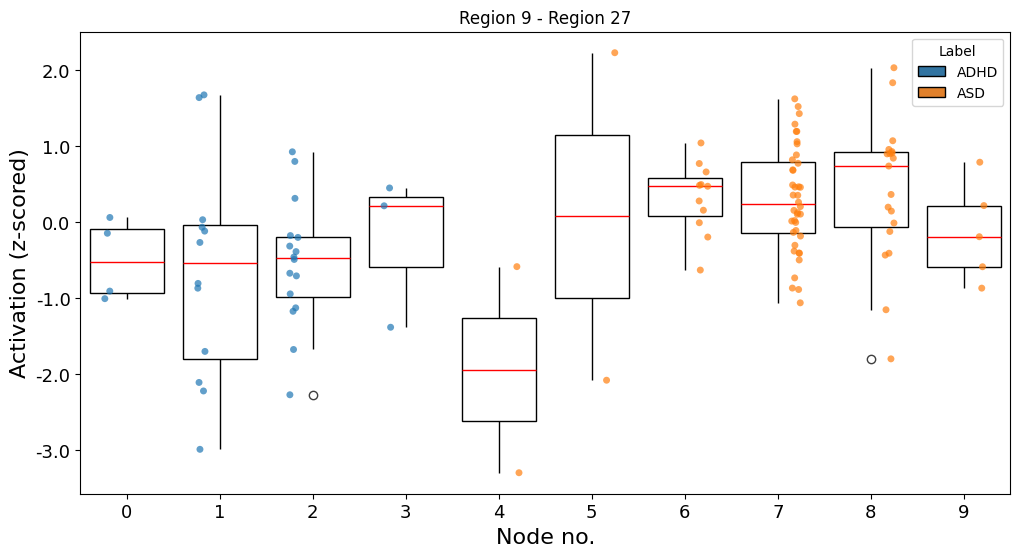

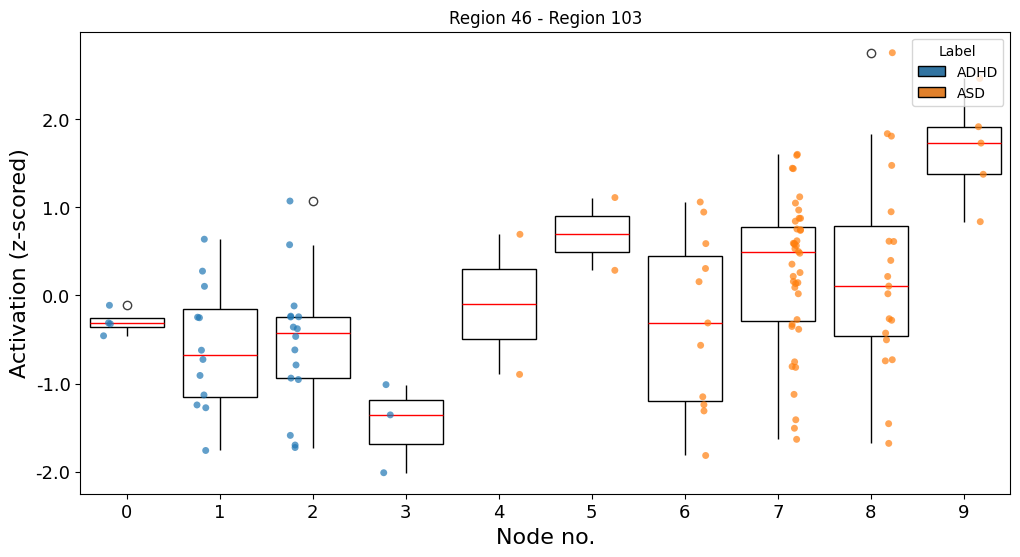

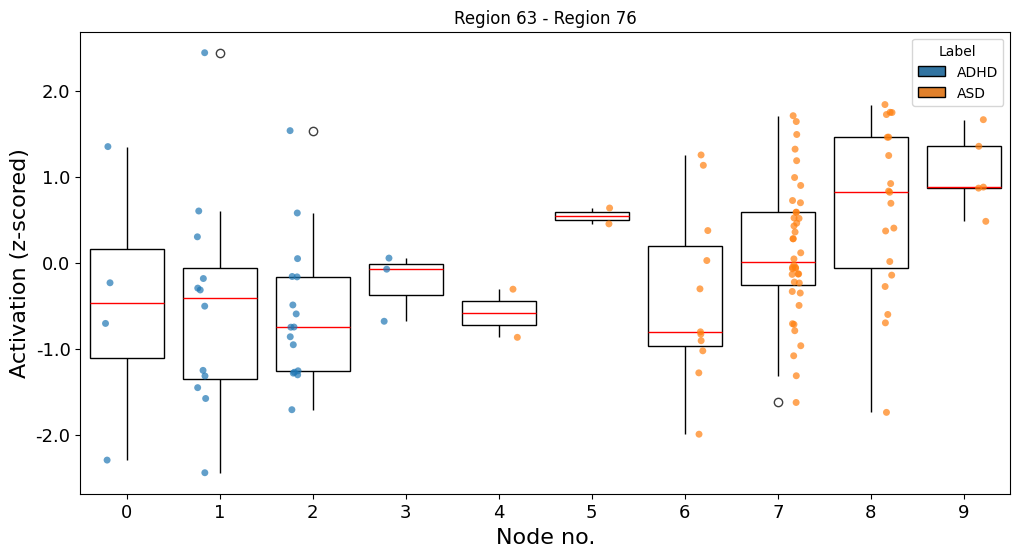

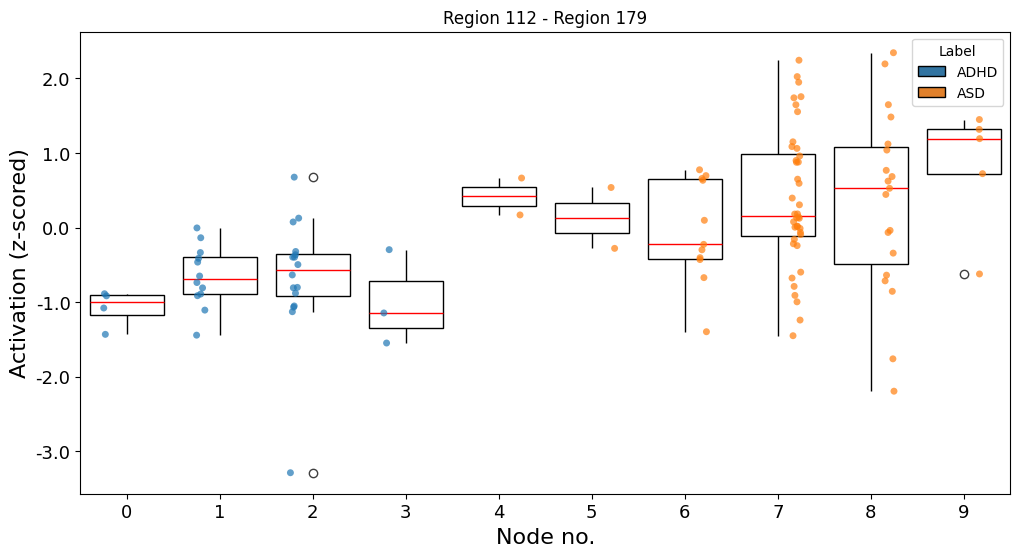

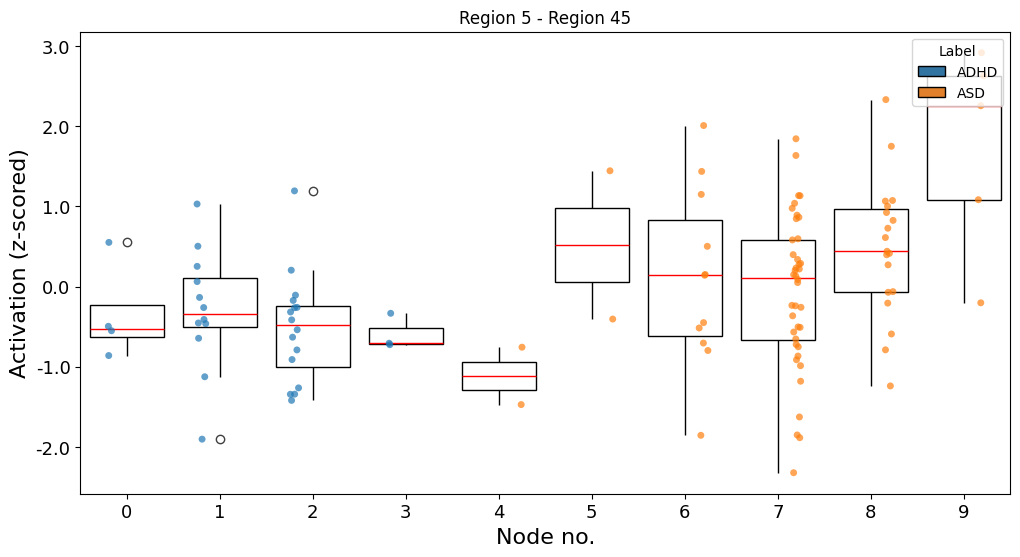

In [ ]:
for n, feature in enumerate(sorted_edge_mapper_features_without_none_increase.keys()):
  regions = feature_to_regions(feature, map_df)
  if n < 5:
    multinodes_paired_boxplot_validation(val_df, feature, [i for i in range(1,16)], f"Region {regions[0]} - Region {regions[1]}")

In [ ]:
def calculate_p_value_feature_between_two_pure_nodes(df, feature, adhd_nodes, asd_nodes):

    # asd_data = []
    # asd_ids = []

    # asd_df = pd.DataFrame()
    # asd_df['node_id'] = asd_ids
    # asd_df['target_feature'] = asd_data

    filt_df = filter_by_multiple_mapper_nodes(graph_file, df, asd_nodes)
    asd_data = filt_df[feature].values
    # asd_ids = [_ for _ in range(len(filt_df))]


    # adhd_data = []
    # adhd_ids = []

    filt_df = filter_by_multiple_mapper_nodes(graph_file, df, adhd_nodes)
    adhd_data = filt_df[feature].values
    # adhd_ids = [_ for _ in range(len(filt_df))]


    # adhd_df = pd.DataFrame()
    # adhd_df['node_id'] = adhd_ids
    # adhd_df['target_feature'] = adhd_data

    # adhd_df = adhd_df.drop_duplicates(subset='node_id', keep='first')

    t_stat, p_value = ttest_ind(asd_data, adhd_data)

    return (t_stat, p_value)


In [ ]:
a, b = calculate_p_value_feature_between_two_pure_nodes(discovery_df, feature, [1,2,3,4,5,6,7,8], [11,12,13,14,15])

In [ ]:
a, b = calculate_p_value_feature_between_two_pure_nodes(discovery_df, 7510, [1,2,3,4,5,6,7,8], [11,12,13,14,15])

In [ ]:
a

-18.951269730448956

In [ ]:
b

8.125692204594711e-64

In [ ]:
import seaborn as sns

def multinodes_paired_boxplot(df, feature, node_ids, title):

    bp_df = pd.DataFrame(columns=['node_id', 'target_feature', 'label'])

    new_ids = []
    data = []
    labels = []
    for node_id in node_ids:
        filt_df = filter_by_mapper_node(graph_file, df, node_id)
        new_ids.extend([node_id for _ in range(len(filt_df))])
        data.extend(filt_df[feature].values)
        labels.extend(filt_df['label'].values)

    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))

    bp_df['node_id'] = new_ids
    bp_df['node_id'] = pd.Categorical(bp_df['node_id'], categories=np.unique(node_ids), ordered=True)

    bp_df['target_feature'] = data
    bp_df['label'] = labels

    fig, ax = plt.subplots(figsize=(12, 6))

    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    custom_palette = {"ADHD": default_colors[0], "ASD": default_colors[1]}  # Blue and orange

    sns.boxplot(
        y='target_feature',
        x='node_id',
        data=bp_df,
        hue='label',
        ax=ax,
        showcaps=False,
        boxprops={'facecolor': 'none', 'edgecolor': 'black'},
        whiskerprops={'color': 'black'},
        medianprops={'color': 'red'},
        palette=custom_palette
    )

    # Add data points behind the transparent boxes without adding them to the legend
    sns.stripplot(
        y='target_feature',
        x='node_id',
        data=bp_df,
        hue='label',
        dodge=True,
        ax=ax,
        alpha=0.7,
        jitter=True,
        legend=False  # Suppress legend for the dots
    )

    ax.set_ylabel("Activation (z-scored)", fontsize=16)
    ax.set_xlabel("Node no.", fontsize=16)
    # Adjust the legend to only reflect the boxplot
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict(zip(labels, handles)).keys())  # Unique labels for boxplot
    ax.legend(handles[:len(unique_labels)], labels[:len(unique_labels)], title='Label', loc='upper right')

    # Adjust aesthetics
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticks(), fontsize=13)
    ax.set_yticklabels(ax.get_yticks(), fontsize=13)

    return fig, ax

def feature_to_regions(feature, map_df):
  row, col = index_to_row_col(feature)
  regions = (row + 1, col + 1)
  return regions

In [ ]:
feature_to_regions(14210, map_df)

(103, 187)

In [ ]:
for n, feature in enumerate(sorted_edge_mapper_features_without_none.keys()):
  regions = feature_to_regions(feature, map_df)
  if n < 20:
    t_stat, p_value = calculate_p_value_feature_between_two_pure_nodes(discovery_df, feature, [1,2,3,4,5,6,7,8], [11,12,13,14,15])
    print(f"{feature} --> {t_stat} - {p_value}")

14210 --> -23.621816517308368 - 5.164909649365618e-89
8743 --> -21.1123246414937 - 2.328902180529423e-75
15657 --> -18.717584595505592 - 1.379275991603773e-62
7665 --> -6.251631916964879 - 7.455528479069077e-10
7510 --> -18.951269730448956 - 8.125692204594711e-64
7937 --> -15.768562675862942 - 1.6257480404828895e-47
15222 --> -19.588851416675748 - 3.420654199867312e-67
9002 --> -15.367649178245992 - 1.5164992065593827e-45
9394 --> -9.795318048037469 - 3.416312193094544e-21
8183 --> -13.616580197307151 - 3.137956767280659e-37
1501 --> 12.956046838521353 - 3.128585033299274e-34
15817 --> -14.692128731262954 - 2.800084513987599e-42
15757 --> -16.8701244647352 - 4.913351483423037e-53
12626 --> -8.313610319708555 - 5.648832672794006e-16
14832 --> -11.468780540319846 - 8.356470492872246e-28
7376 --> -12.632116133543008 - 8.608625977864616e-33
1076 --> -17.230197963369122 - 7.181702329863753e-55
17044 --> -9.28305618128012 - 2.5677152923355047e-19
14940 --> 12.429391356682588 - 6.683268028751

In [ ]:
calculate_p_value_feature_between_two_pure_nodes(discovery_df, feature, [1,2,3,4,5,6,7,8], [11,12,13,14,15])

(1.3070061307954637, 0.19153300769663917)

<ipython-input-86-3a9e68f593bb>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-86-3a9e68f593bb>:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-86-3a9e68f593bb>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-86-3a9e68f593bb>:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-86-3a9e68f593bb>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

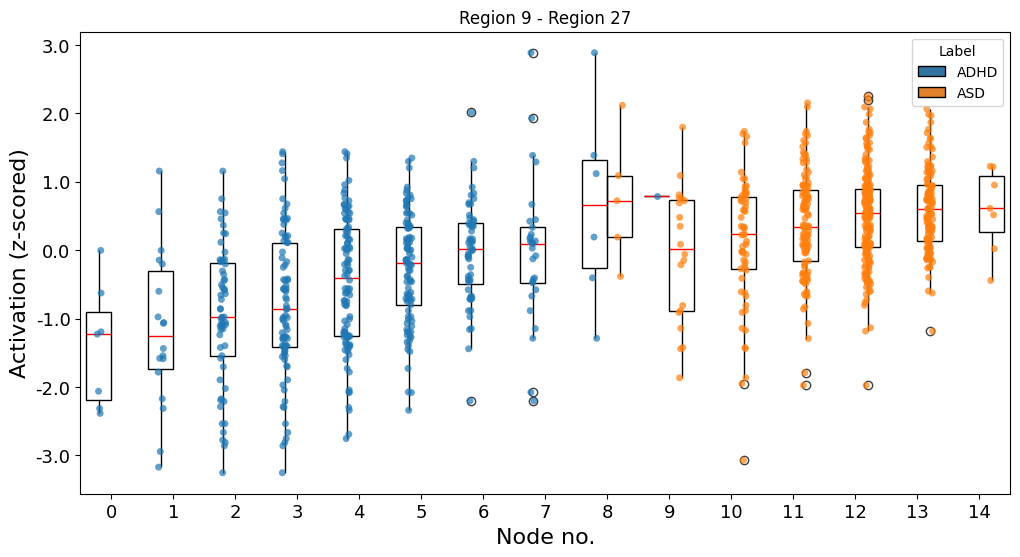

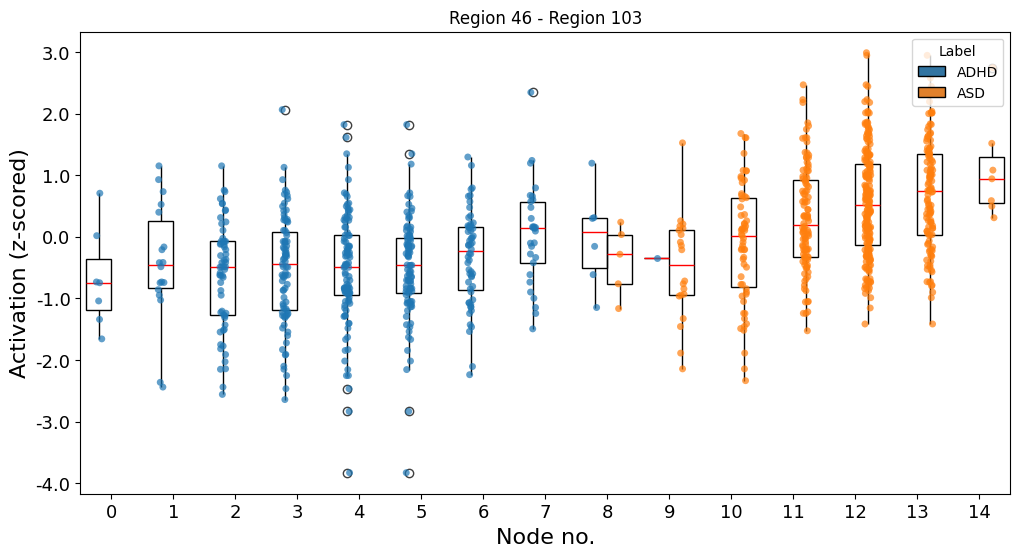

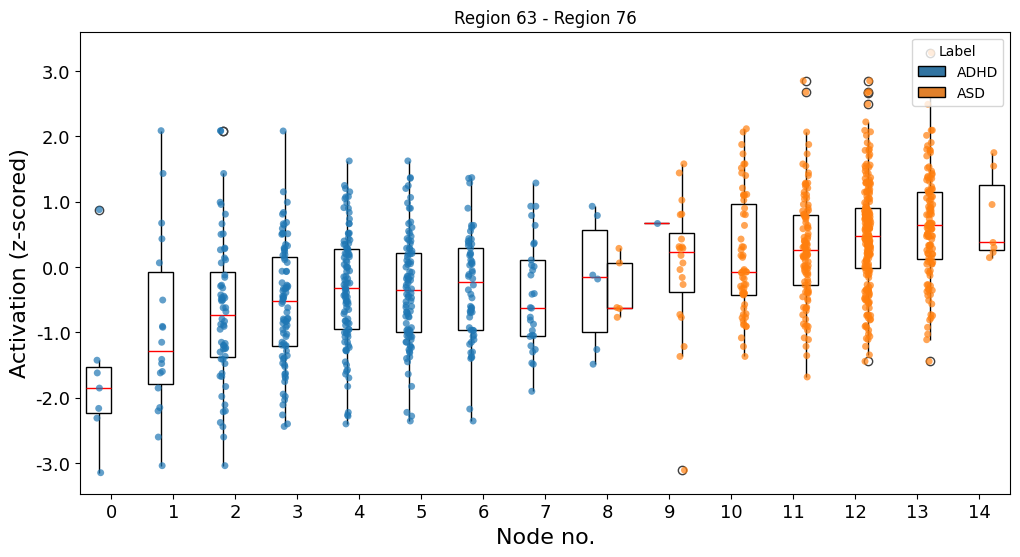

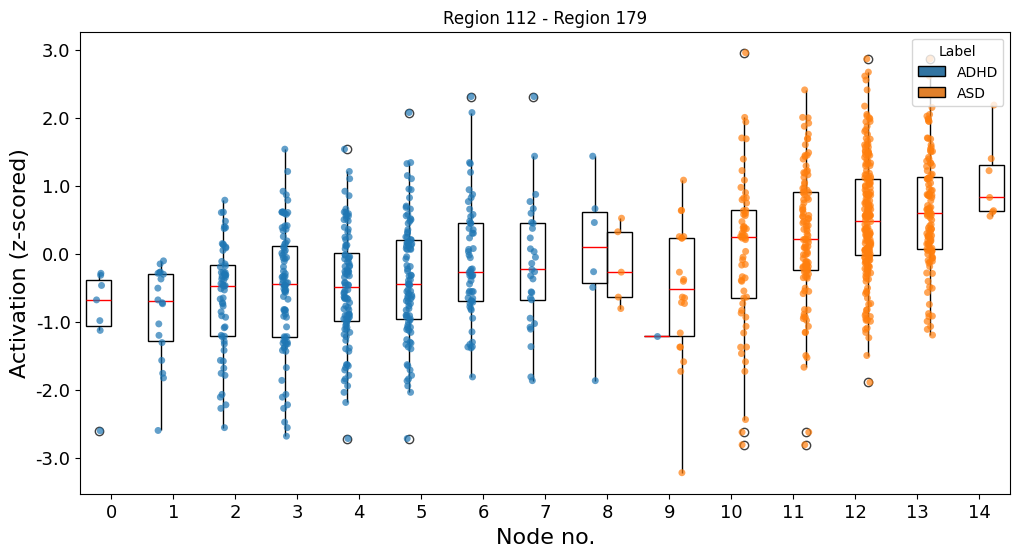

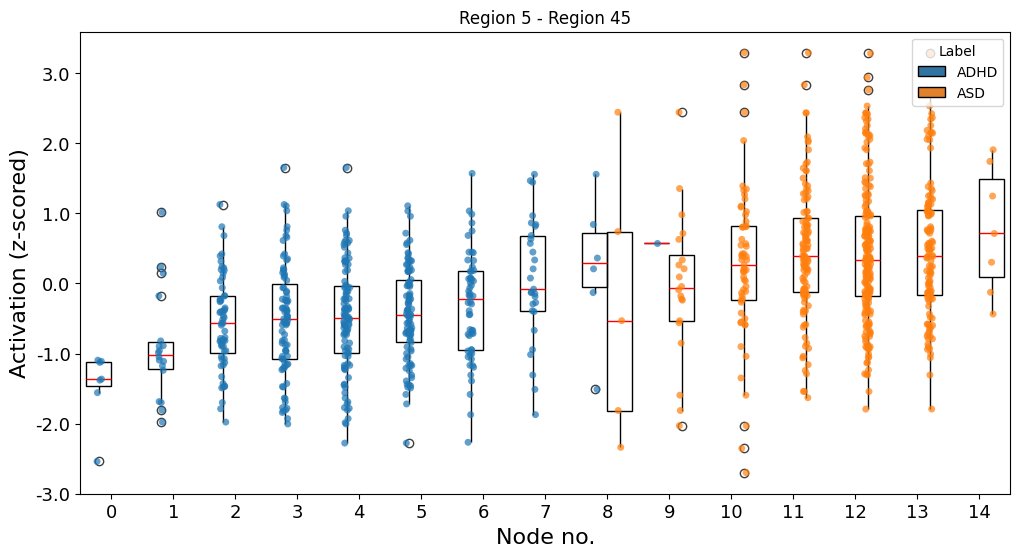

In [ ]:
for n, feature in enumerate(sorted_edge_mapper_features_without_none_increase.keys()):
  regions = feature_to_regions(feature, map_df)
  if n < 5:
    multinodes_paired_boxplot(discovery_df, feature, [i for i in range(1,16)], f"Region {regions[0]} - Region {regions[1]}")

<ipython-input-83-b0633d3b1bc5>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-83-b0633d3b1bc5>:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-83-b0633d3b1bc5>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-83-b0633d3b1bc5>:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-83-b0633d3b1bc5>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

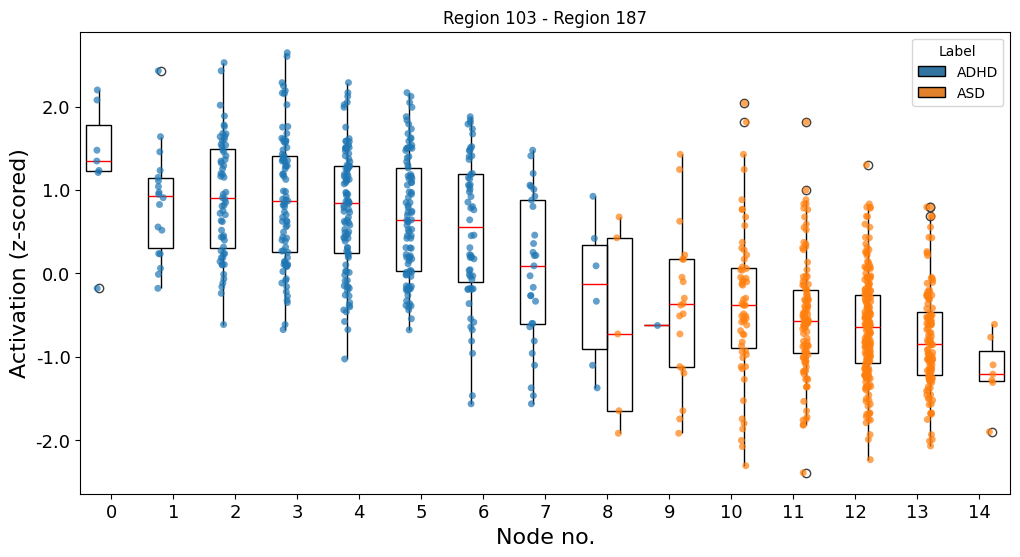

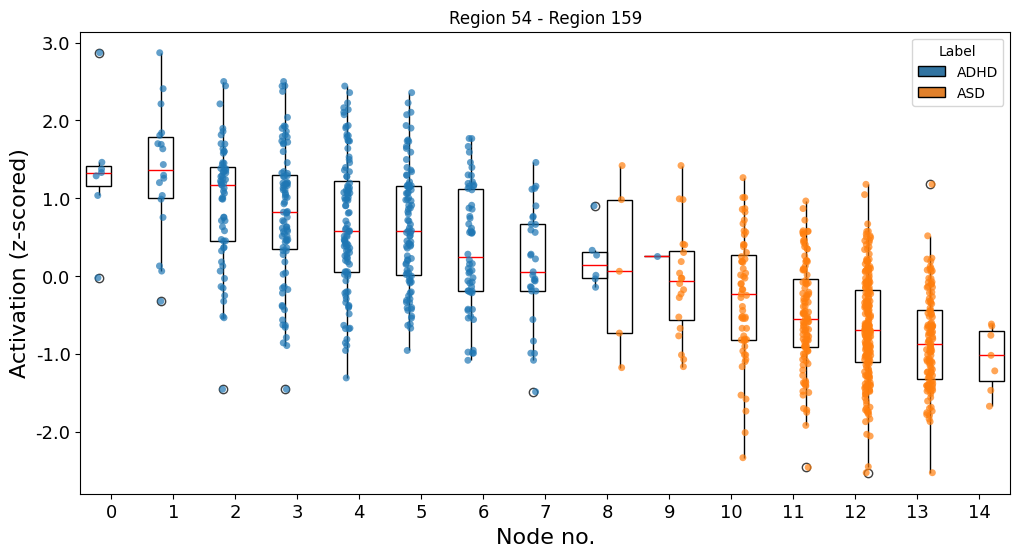

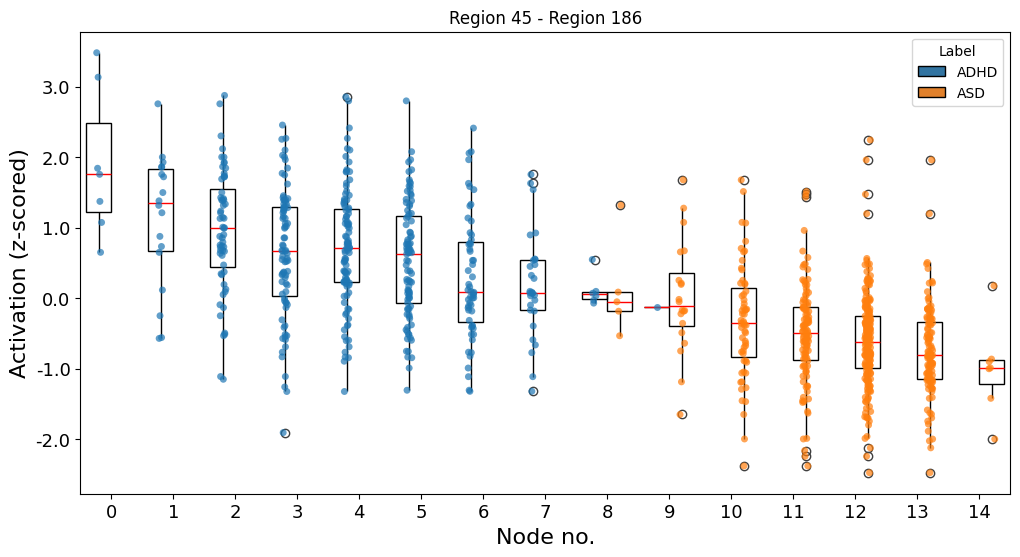

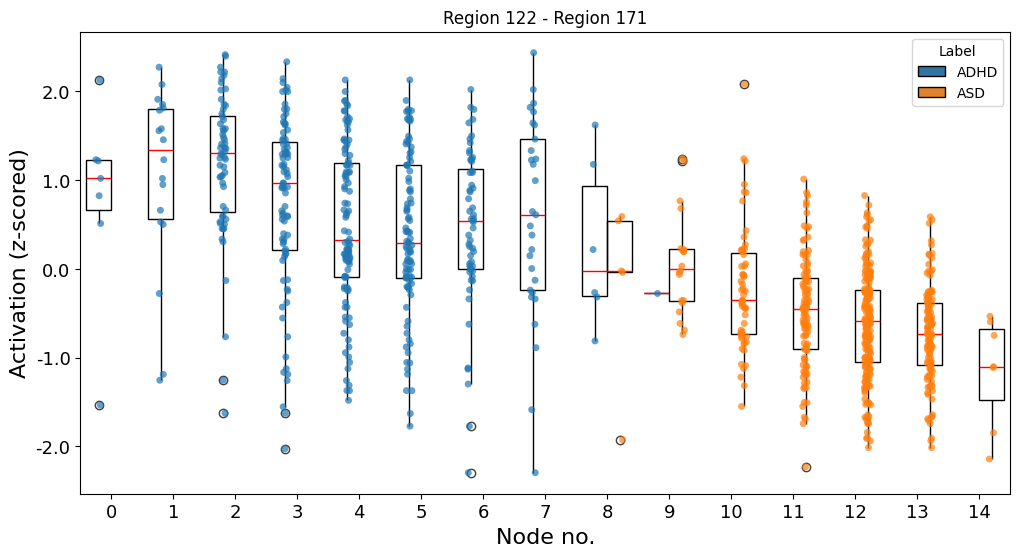

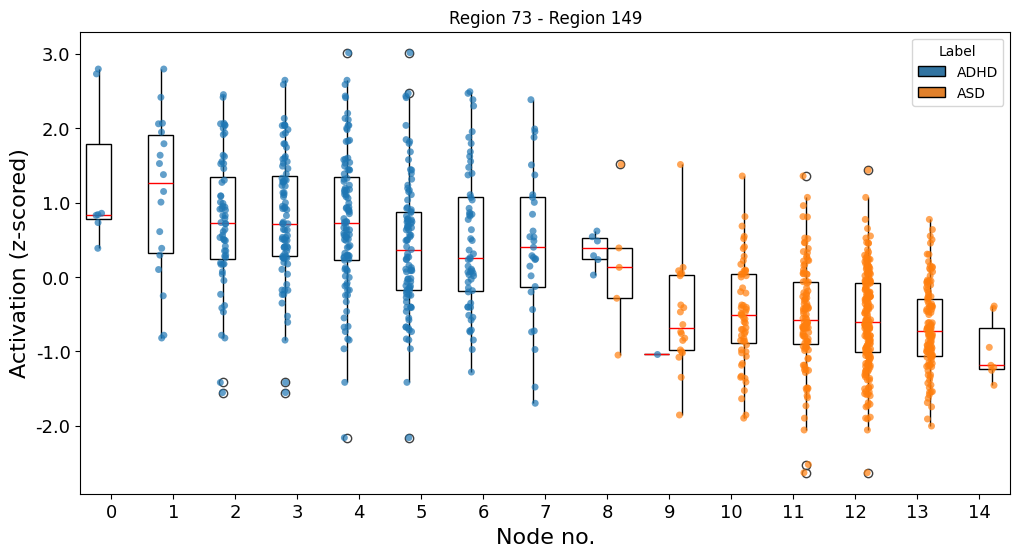

In [ ]:
for n, feature in enumerate(sorted_edge_mapper_features_without_none_decrease.keys()):
  regions = feature_to_regions(feature, map_df)
  if n < 5:
    multinodes_paired_boxplot(discovery_df, feature, [i for i in range(1,16)], f"Region {regions[0]} - Region {regions[1]}")

(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]
(114, 3)


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


[ 3  4  5  6  7  8  9 10 11 12]
(114, 3)


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


[ 3  4  5  6  7  8  9 10 11 12]
(114, 3)


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


[ 3  4  5  6  7  8  9 10 11 12]
(114, 3)


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


[ 3  4  5  6  7  8  9 10 11 12]


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


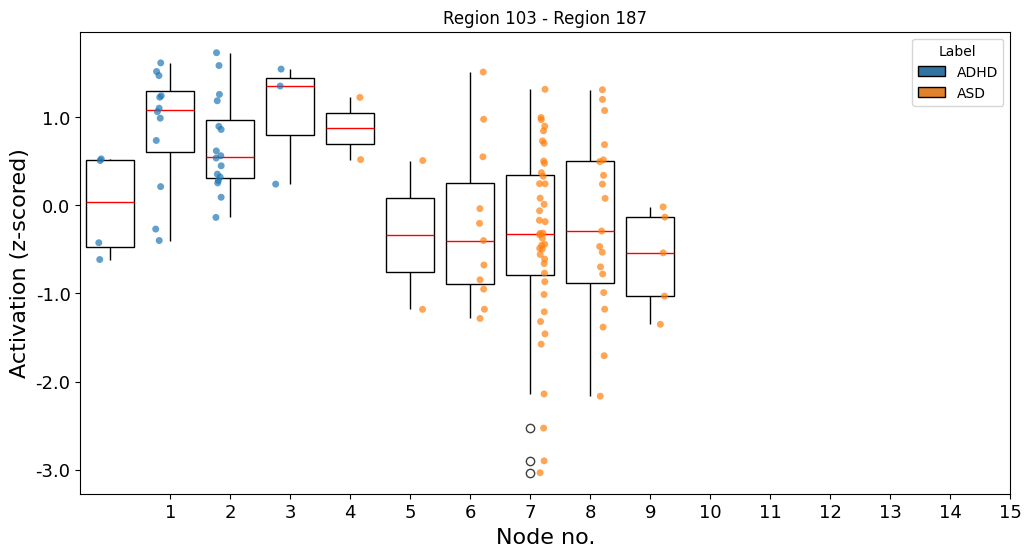

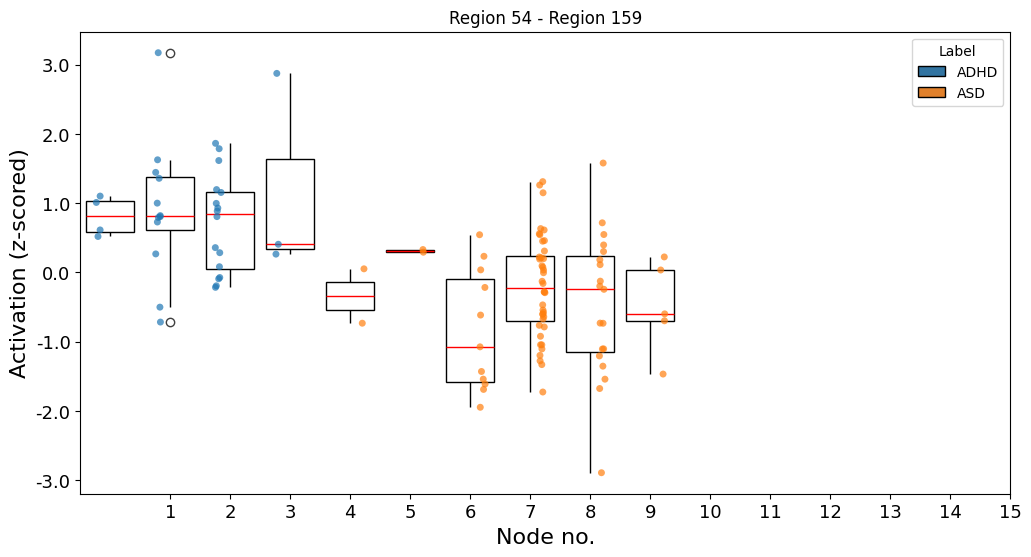

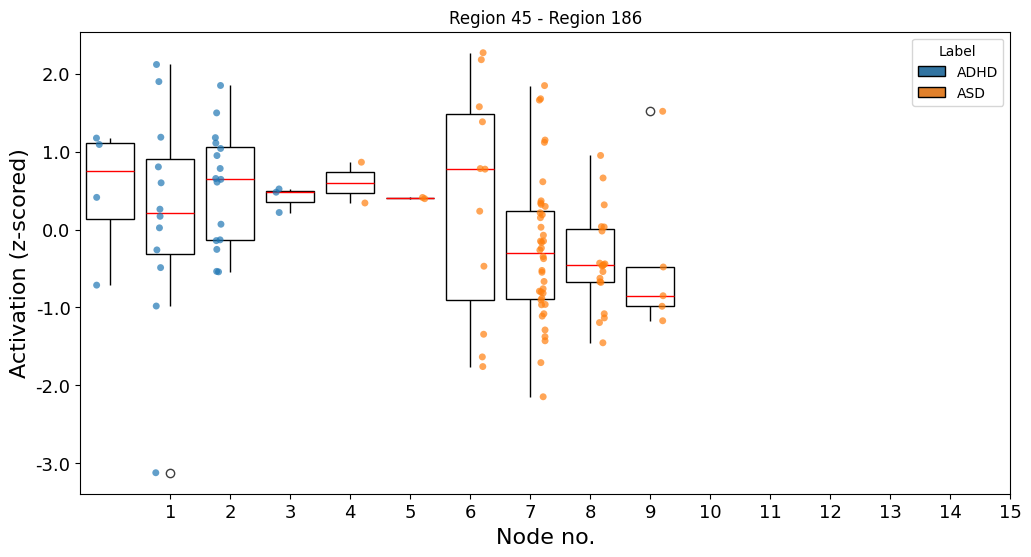

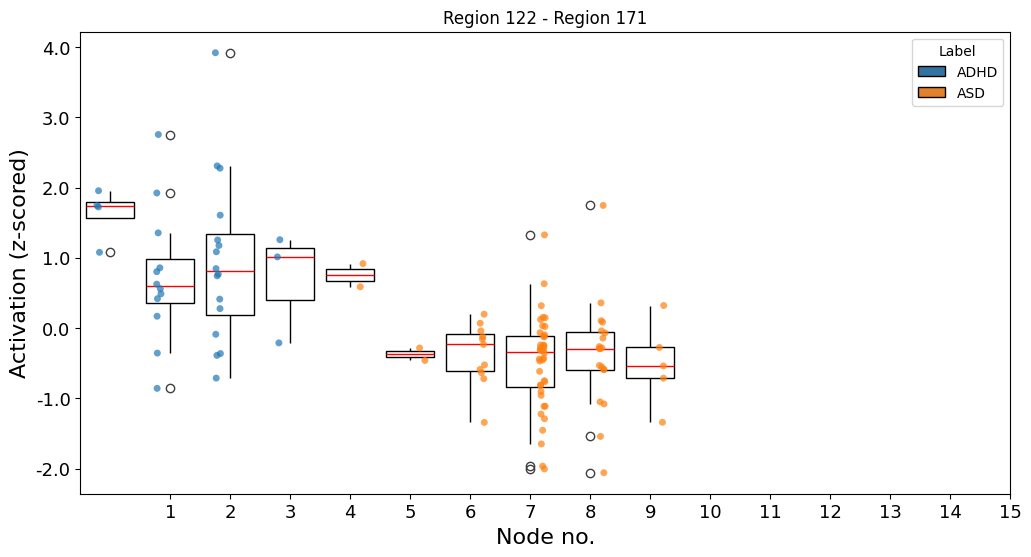

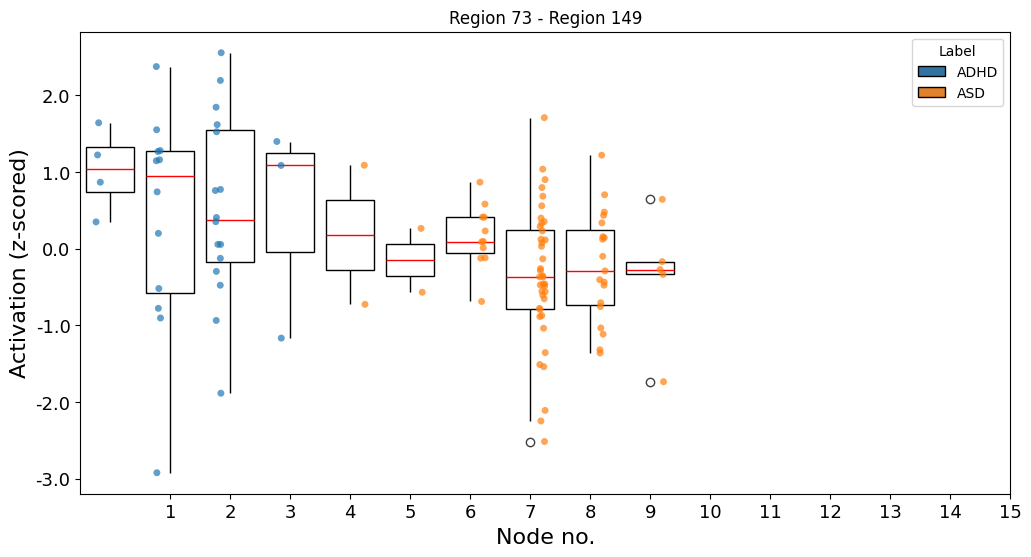

In [ ]:
for n, feature in enumerate(sorted_edge_mapper_features_without_none_decrease.keys()):
  regions = feature_to_regions(feature, map_df)
  if n < 5:
    multinodes_paired_boxplot_validation(val_df, feature, [i for i in range(1,16)], f"Region {regions[0]} - Region {regions[1]}")

In [ ]:
np.unique(val_df['bin'])

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

<ipython-input-39-1f7780009161>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-39-1f7780009161>:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-39-1f7780009161>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-39-1f7780009161>:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-39-1f7780009161>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

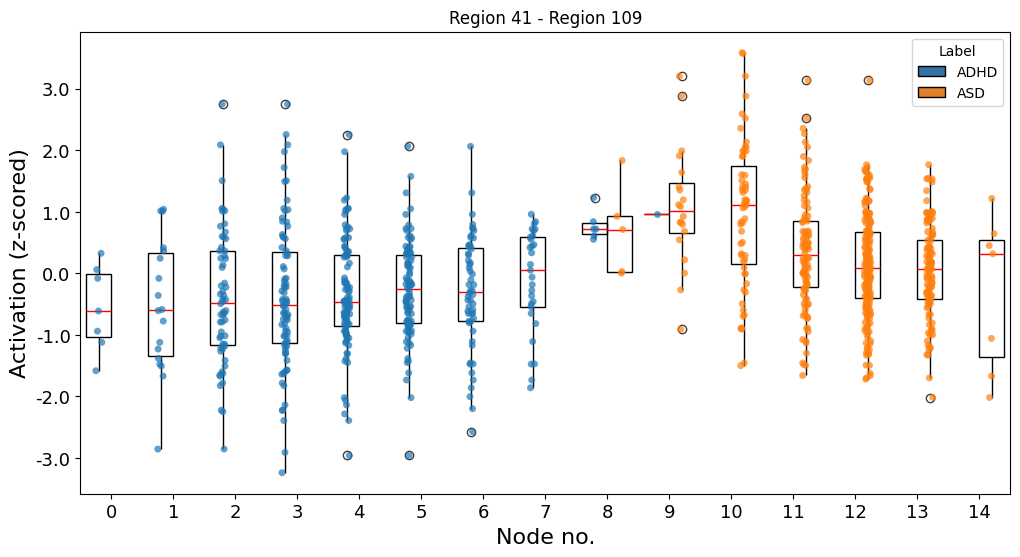

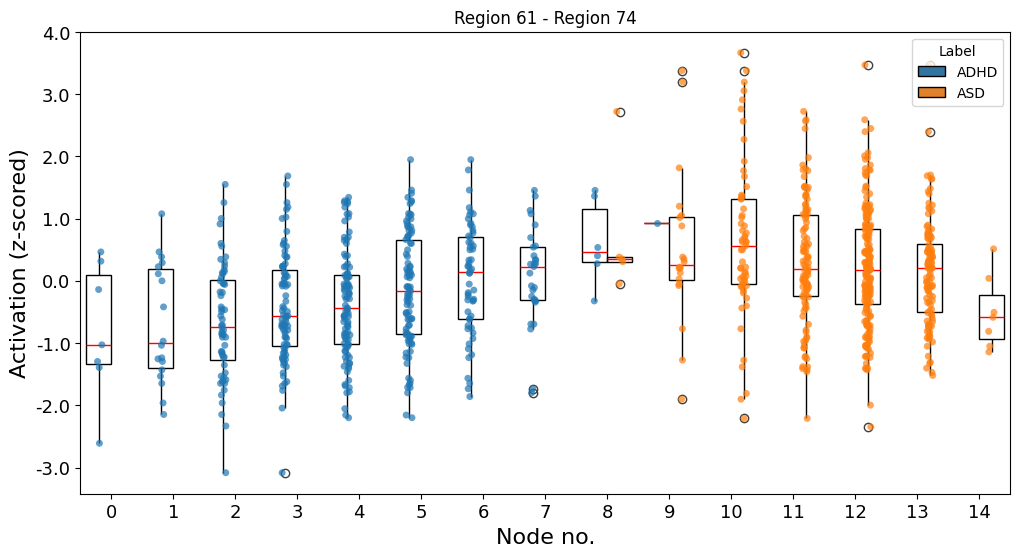

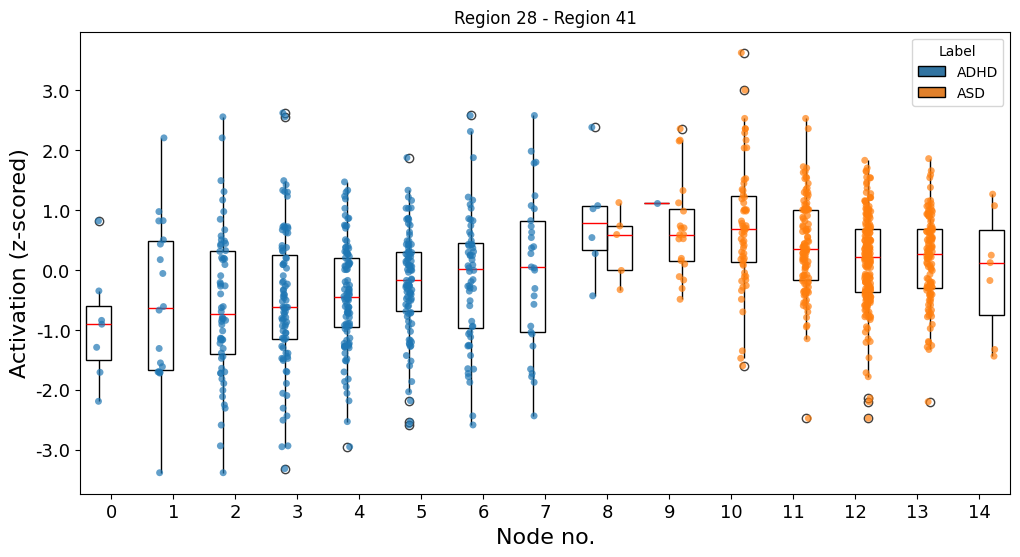

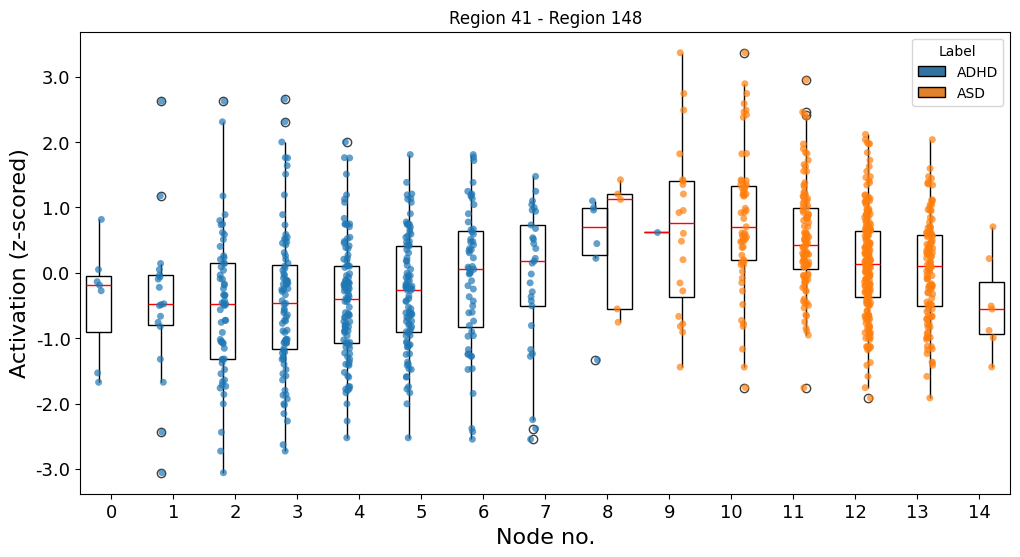

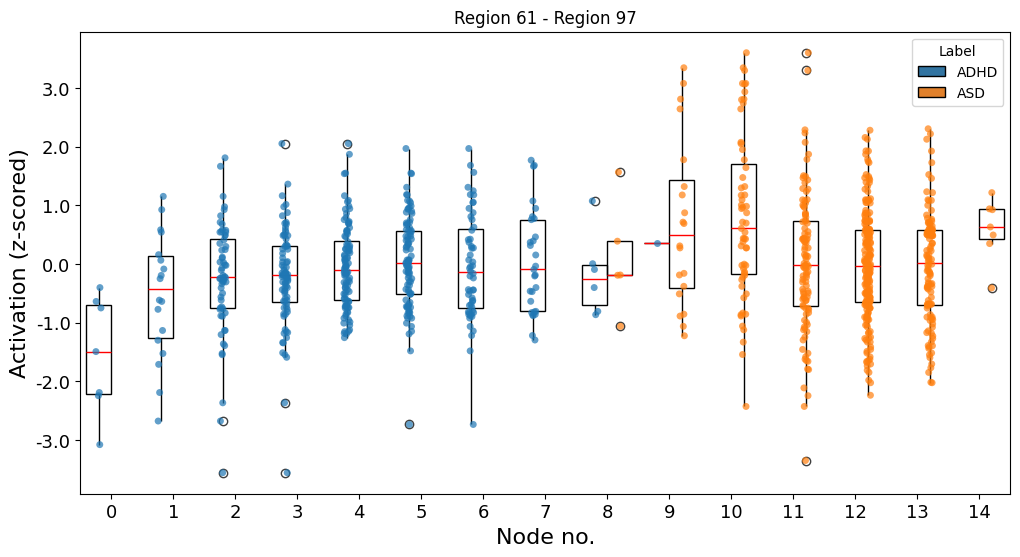

In [ ]:
for n, feature in enumerate(edge_mapper_features_max_optimum.keys()):
  regions = feature_to_regions(feature, map_df)
  multinodes_paired_boxplot(discovery_df, feature, [i for i in range(1,16)], f"Region {regions[0]} - Region {regions[1]}")

(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]
(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]
(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


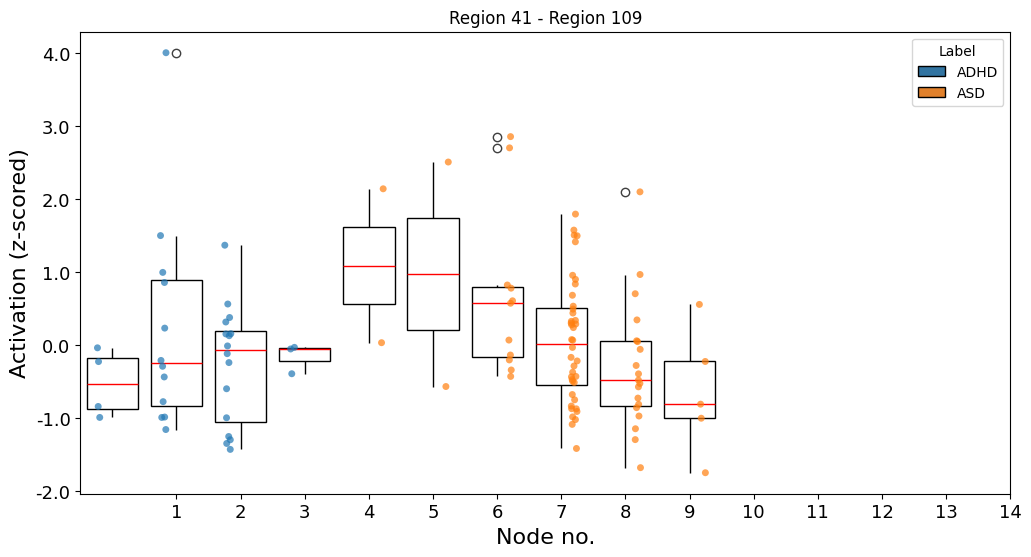

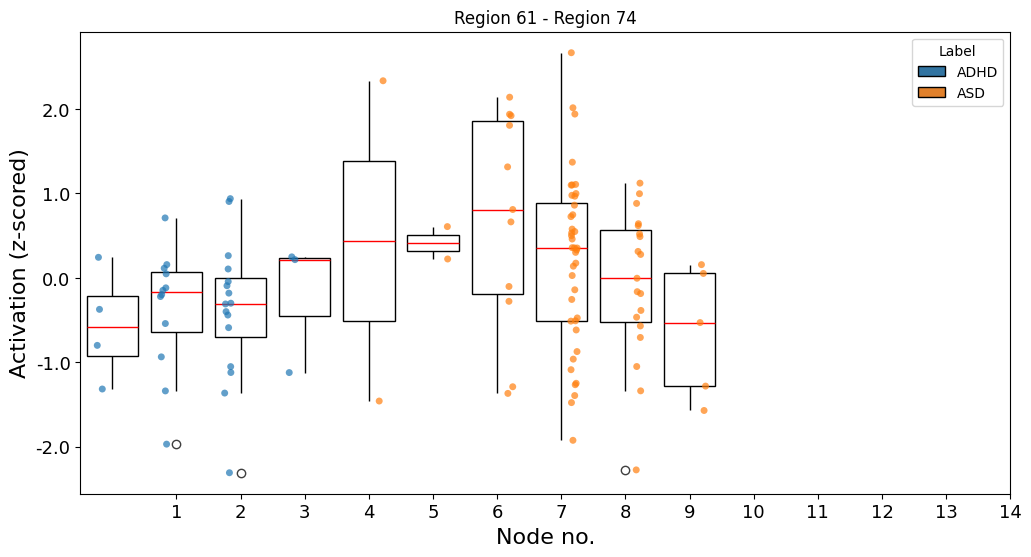

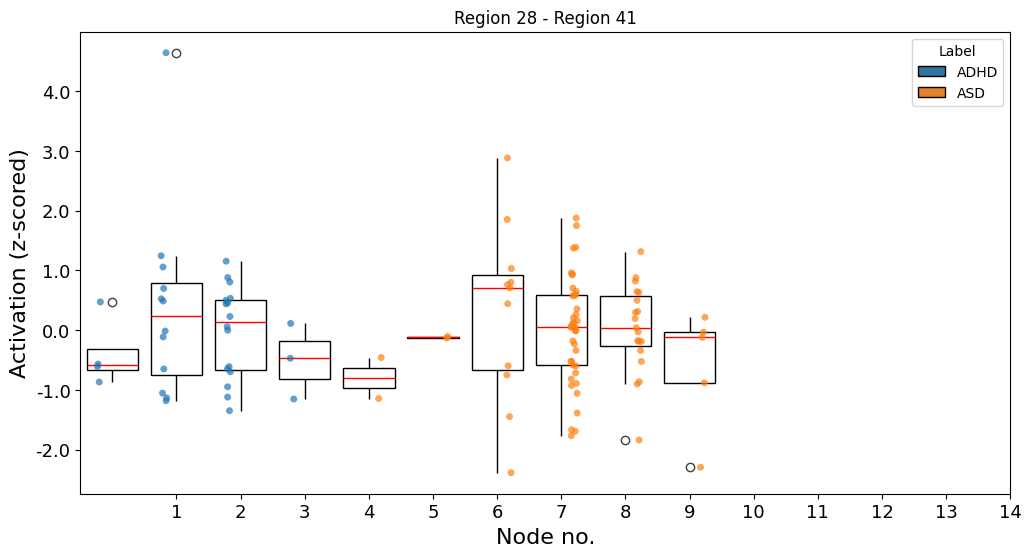

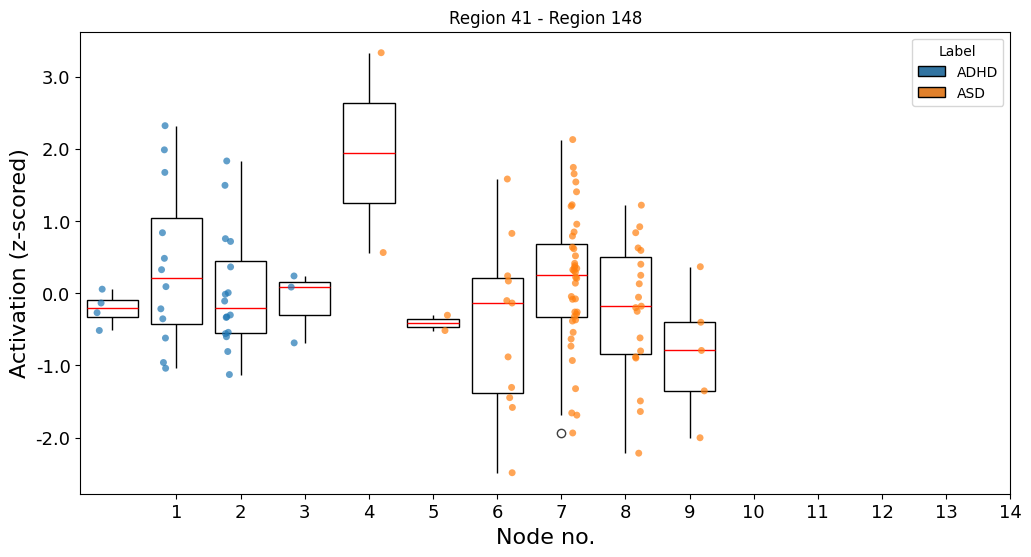

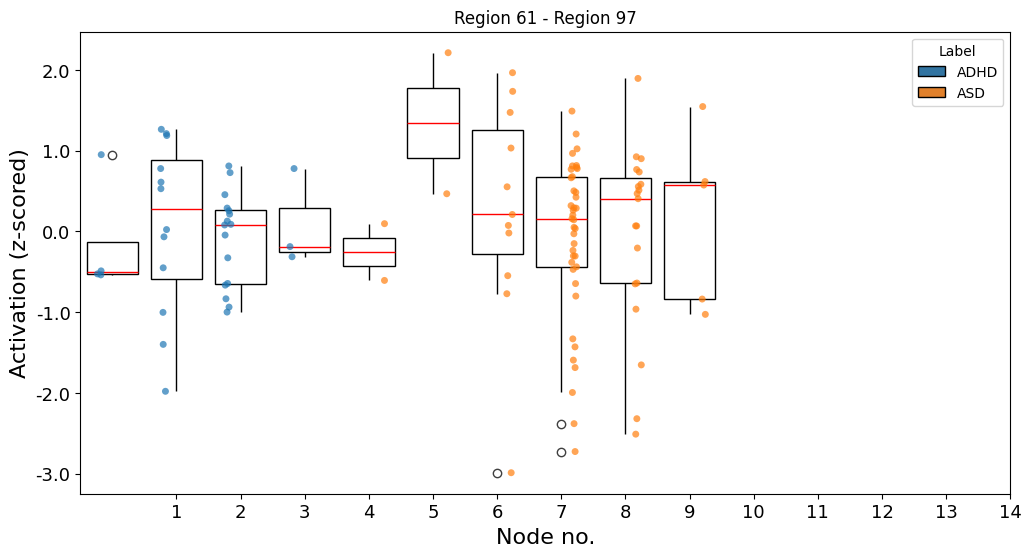

In [ ]:
for n, feature in enumerate(edge_mapper_features_max_optimum.keys()):
  regions = feature_to_regions(feature, map_df)
  multinodes_paired_boxplot_validation(val_df, feature, [i for i in range(1,15)], f"Region {regions[0]} - Region {regions[1]}")

<ipython-input-39-1f7780009161>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-39-1f7780009161>:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-39-1f7780009161>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=13)
<ipython-input-39-1f7780009161>:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-39-1f7780009161>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

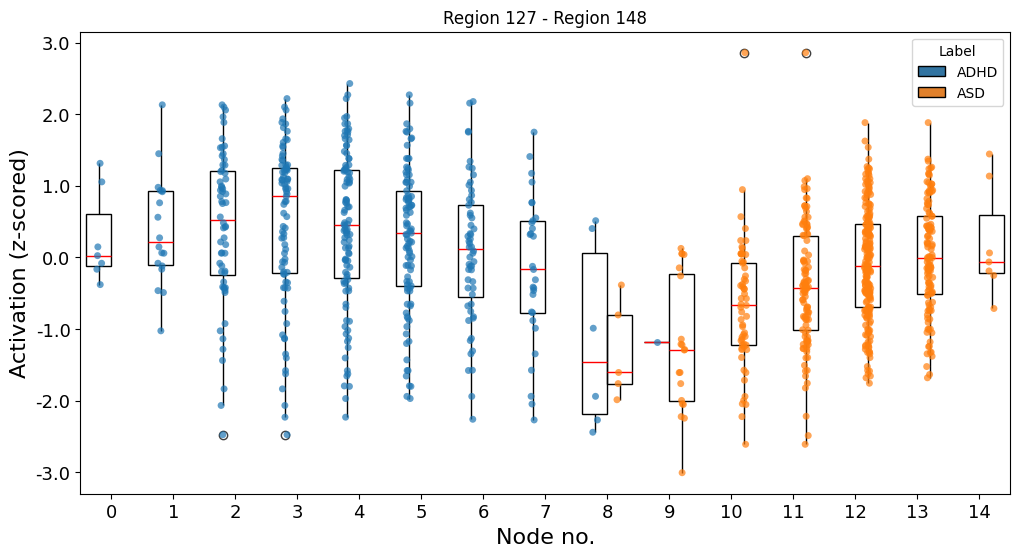

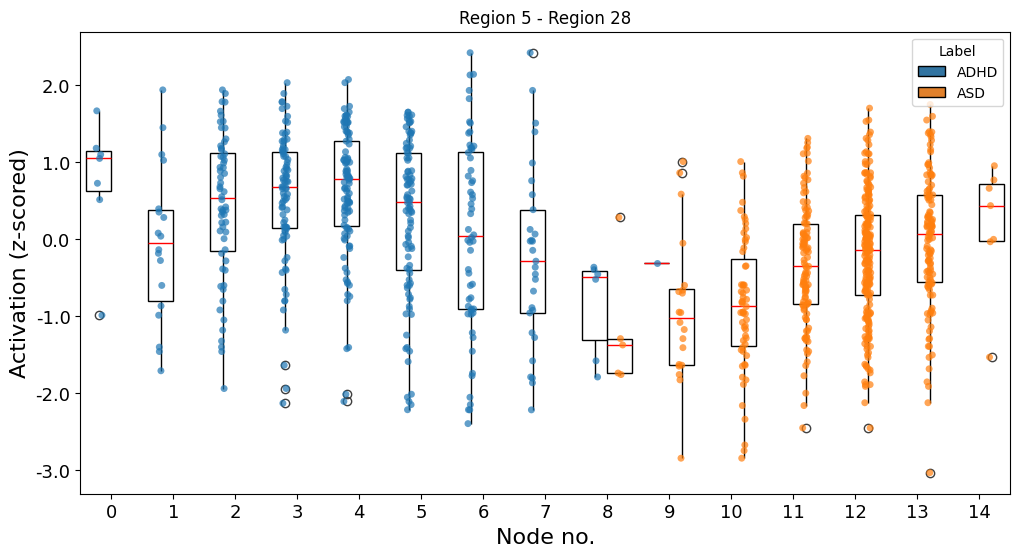

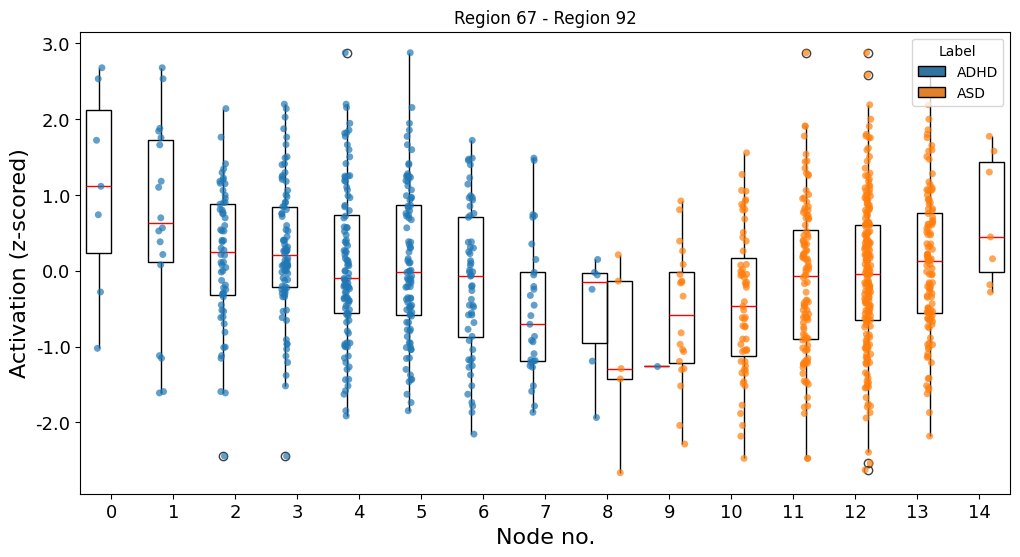

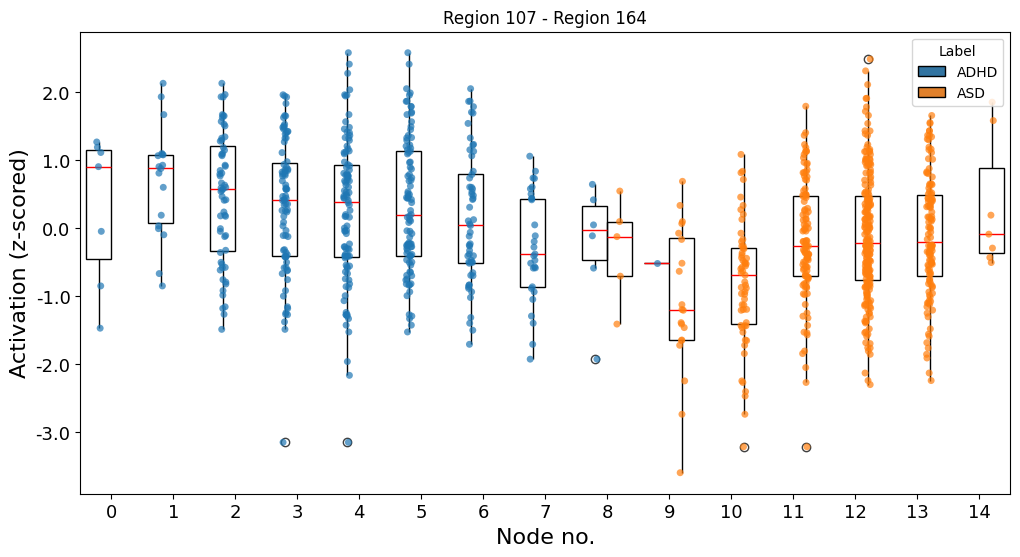

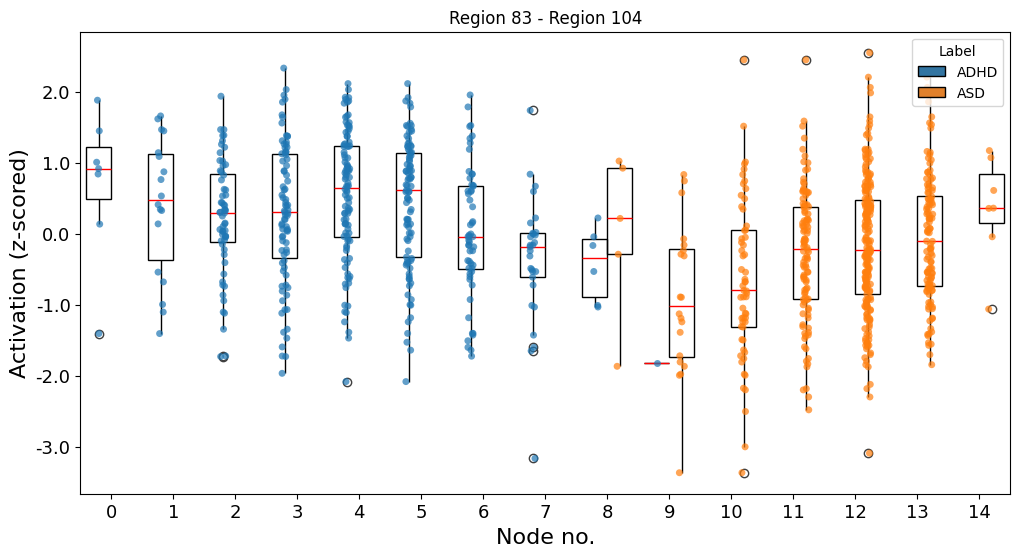

In [ ]:
for n, feature in enumerate(edge_mapper_features_min_optimum.keys()):
  if (n < 5):
    regions = feature_to_regions(feature, map_df)
    multinodes_paired_boxplot(discovery_df, feature, [i for i in range(1,16)], f"Region {regions[0]} - Region {regions[1]}")

(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]
(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)
<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


(114, 3)
[ 3  4  5  6  7  8  9 10 11 12]
(114, 3)


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


[ 3  4  5  6  7  8  9 10 11 12]


<ipython-input-35-c26dd0dc0ef0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=13)


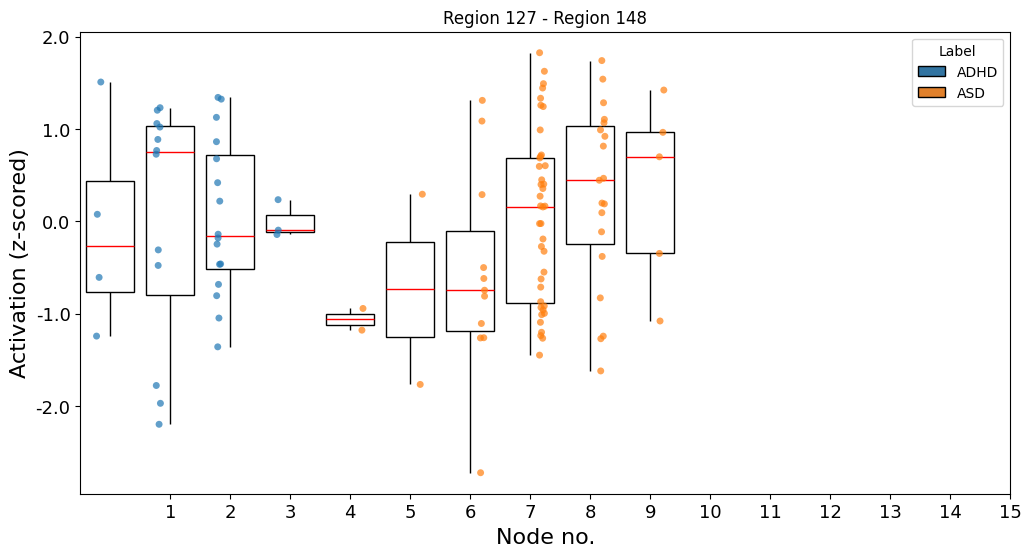

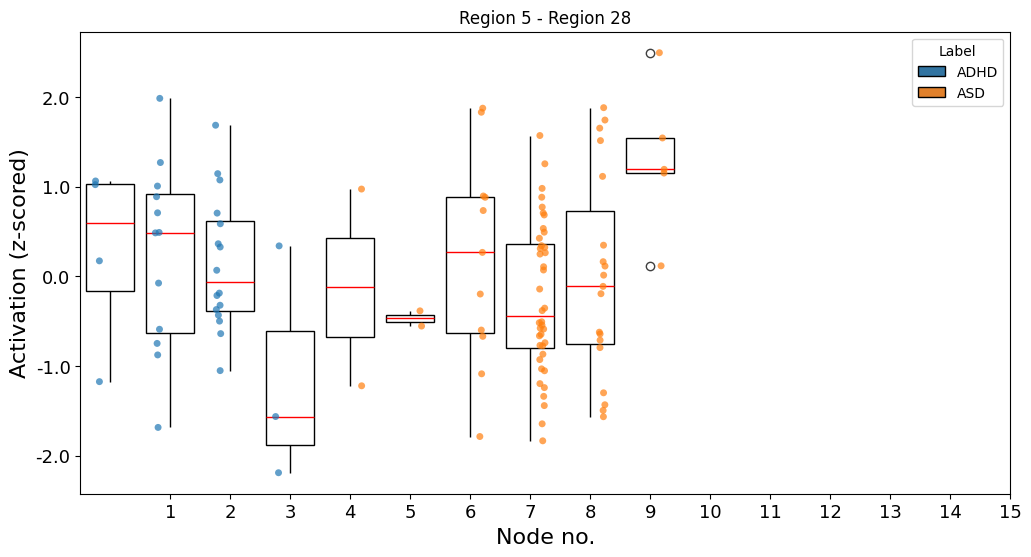

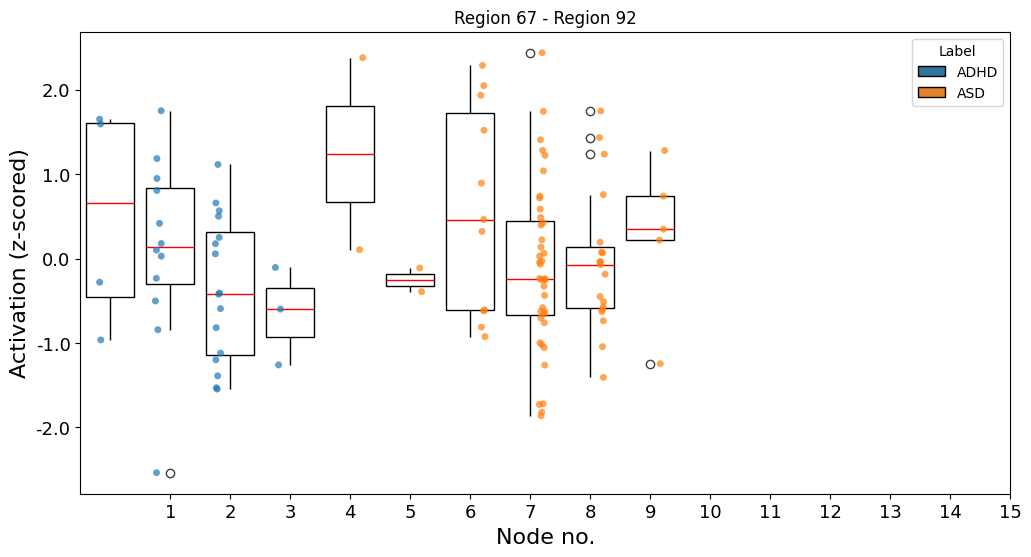

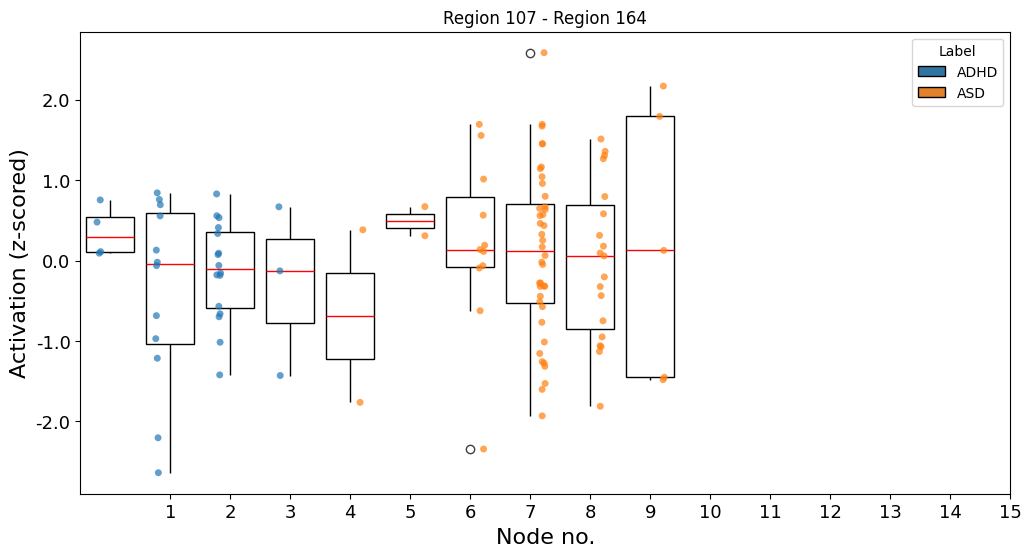

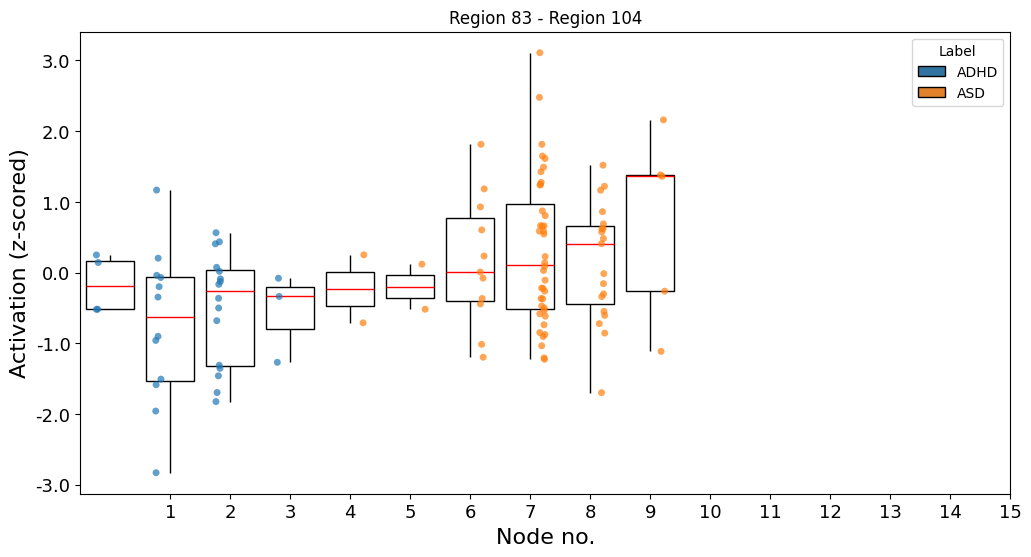

In [ ]:
for n, feature in enumerate(edge_mapper_features_min_optimum.keys()):
  if (n < 5):
    regions = feature_to_regions(feature, map_df)
    multinodes_paired_boxplot_validation(val_df, feature, [i for i in range(1,16)], f"Region {regions[0]} - Region {regions[1]}")

In [ ]:
net_df[net_df['roi_no']==66]

roi_no             name  net_id                        sys_name
65      66  Rolandic_Oper_R       3  Cingulo-opercular Task Control

In [ ]:
net_df[net_df['roi_no']==182]

roi_no        name  net_id                  sys_name
181     182  Fusiform_R       1  Sensory/somatomotor Hand

In [ ]:
net_df[net_df['roi_no']==59]

roi_no             name  net_id sys_name
58      59  Occipital_Mid_R       7   Visual

In [ ]:
net_df[net_df['roi_no']==118]

roi_no       name  net_id      sys_name
117     118  Angular_L       5  Default mode